In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

import re
import unidecode

from sklearn import preprocessing
from sklearn import ensemble
from sklearn import linear_model

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, SVR
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import normalize, StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.decomposition import PCA, TruncatedSVD

/Users/davidmertenjones/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
plt.rcParams['figure.figsize'] = 8, 8

plt.style.use('dark_background')

# Wine Reviews

https://www.kaggle.com/zynicide/wine-reviews

## Overview:

This dataset was scraped from Wine Enthusiast by Zach Thoutt, and posted on Kaggle. His overall goal with the dataset is to create a wine identifier based on description but here the goal is different; however, the purpose of this model will be to predict price and/or rating based on origin, varietal, and description of a wine.

### Limitations/Unavailable Data:

Percent alcohol by volume is ubiquitous information on wine labels, but it is missing from this dataset.

The "points" ratings in this set are all between 80 and 100 points.

Lastly, the ratings are all subjective, as are the individual descriptions by the sommeliers. We do not know if the sommeliers whose descriptions appear in this dataset are all certified.

## Data Description:

### winemag-data-130k-v2.json

country - The country that the wine is from

description - A few sentences from a sommelier describing the wine's taste, smell, look, feel, etc.

designation - The vineyard within the winery where the grapes that made the wine are from

points - The number of points WineEnthusiast rated the wine on a scale of 1-100 (though they say 
they only post reviews for wines that score >=80)

price - The cost for a bottle of the wine

province - The province or state that the wine is from

region_1 - The wine growing area in a province or state (ie Napa)

region_2 - Sometimes there are more specific regions specified within a wine growing area (ie Rutherford inside the Napa Valley), but this value can sometimes be blank

taster_name - Name of the person who tasted and reviewed the wine

taster_twitter_handle - Twitter handle for the person who tasted and reviewed the wine

title - The title of the wine review, which often contains the vintage if you're interested in extracting that feature

variety - The type of grapes used to make the wine (ie Pinot Noir)

winery - The winery that made the wine


There are two other files in this dataset, one of which is the same information but without "taster_name," "taster_twitter_handle," or "title," and the other is the first 150000 reviews, also without those three columns. I have chosen to use winemag-data-130k-v2.json because the "title" column contains vintage in the vast majority of entries. The first step in cleaning the data will be to extract the year from "title."

In [3]:
df0 = pd.read_json('wine-reviews/winemag-data-130k-v2.json')
df0 = df0.drop(['taster_name', 'taster_twitter_handle', 'region_2'], 1)

### "Vintage:"

In [4]:
df0.title.head()

0                    Nicosia 2013 Vulkà Bianco  (Etna)
1        Quinta dos Avidagos 2011 Avidagos Red (Douro)
2        Rainstorm 2013 Pinot Gris (Willamette Valley)
3    St. Julian 2013 Reserve Late Harvest Riesling ...
4    Sweet Cheeks 2012 Vintner's Reserve Wild Child...
Name: title, dtype: object

In [270]:
def extract_vintage(x):
    """Some titles have a year in their name other than vintage, usually the name of the winery,
    sometimes the age of the grape vines themselves. This function returns the highest four-digit
    number in the input string, assuming vintage is the most recent year in the wine review's title."""
    """Works for up to three instances of a four-digit number."""
    try:
        years = []
        matches = re.findall(r'(\d{4})', x)
        for match in matches:
            years.append(int(match))
        return max(years)
    except ValueError:
        return 0

In [265]:
# Ex.1: "Hazlitt 1852 Vineyards" is the name of the winery, 2013 is the vintage.
extract_vintage('Hazlitt 1852 Vineyards 2013 Dry Riesling (Fing...)')

2013

In [266]:
# Ex.2: "Vignes de 1940" refers to the age of the grape vine, not the vintage.
extract_vintage('Domaine Dupré 2011 Vignes de 1940 (Beaujolais...')

2011

In [267]:
extract_vintage('Don Cristobal 1492 2010 1492 Red (Mendoza)')


2010

In [271]:
extract_vintage('No year information')


0

In [9]:
# Create 'vintage' feature:

df0['vintage'] = df0['title'].apply(lambda x: extract_vintage(x))

In [10]:
df0 = df0[(df0['vintage'] > 0) & (df0['vintage'] <= 2018)]

In [11]:
df0['vintage'].describe()

count    125293.000000
mean       2010.655464
std           4.457951
min        1503.000000
25%        2009.000000
50%        2011.000000
75%        2013.000000
max        2017.000000
Name: vintage, dtype: float64

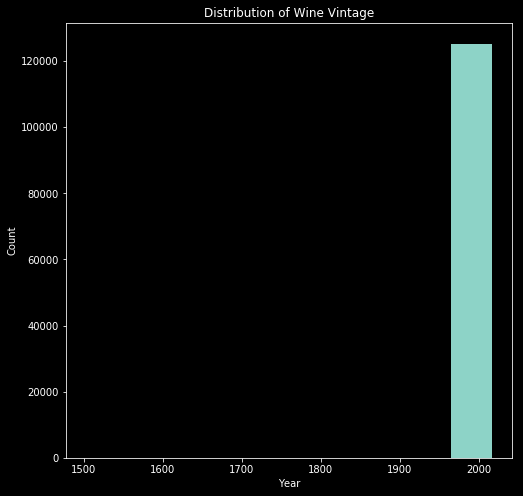

In [12]:
plt.hist(df0['vintage'])
plt.title('Distribution of Wine Vintage')
plt.xlabel('Year')
plt.ylabel('Count')
plt.show()

It looks like there are still some anomalous values in the 'vintage' column, likey due to the review title containing the year the winery was established, instead of the year of vintage. Let's pare it down further to reduce the number of outliers.

In [13]:
# % of entries 
len(df0[(df0['vintage'] >= 1970) & (df0['vintage'] <= 2018)])/len(df0)

0.9996727670340722

In [14]:
# % of entries 
len(df0[(df0['vintage'] >= 1993) & (df0['vintage'] <= 2018)])/len(df0)

0.999209852106662

In [15]:
df0 = df0[(df0['vintage'] >= 1993) & (df0['vintage'] <= 2018)]

In [16]:
df0['vintage'].describe()

count    125194.000000
mean       2010.703756
std           3.533514
min        1993.000000
25%        2009.000000
50%        2011.000000
75%        2013.000000
max        2017.000000
Name: vintage, dtype: float64

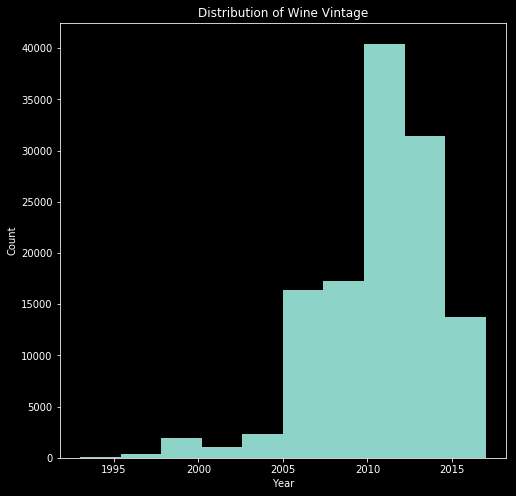

In [17]:
plt.hist(df0['vintage'])
plt.title('Distribution of Wine Vintage')
plt.xlabel('Year')
plt.ylabel('Count')
plt.show()

Though this distribution still shows a fair amount of left-skewness, this looks much better. A 25-year window lets us control for outliers.

In [18]:
df0.head()

,country,description,designation,points,price,province,region_1,title,variety,winery,vintage
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia,2013
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,None,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,2011
2,US,"Tart and snappy, the flavors of lime flesh and...",None,87,14.0,Oregon,Willamette Valley,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm,2013
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,2013
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,2012


### Overall Missingness

In [19]:
# Missingness:

df0.isnull().sum()/df0.shape[0]


country        0.000487
description    0.000000
designation    0.296755
points         0.000000
price          0.068022
province       0.000487
region_1       0.164896
title          0.000000
variety        0.000008
winery         0.000000
vintage        0.000000
dtype: float64

Here we have a fairly large amount of missingness in "designation" and "region_1." Fortunately, we do not need all the information from these columns to build our model. Price is the next highest in terms of missing information. Here we could impute price by substituting the mean, but since price is one of our potential target variables, it's probably best just to omit the entries without price data.

In [20]:
# Fill in "NaN" values for "designation" and "region_1" columns:

df0['designation'] = df0['designation'].fillna('None')
df0['region_1'] = df0['region_1'].fillna('None')

In [21]:
# Excise other missing information:

df0 = df0.dropna()

In [22]:
df0.describe()

,points,price,vintage
count,116618.000000,116618.000000,116618.000000
mean,88.455298,35.403171,2010.754155
std,3.044239,40.786711,3.549739
min,80.000000,4.000000,1993.000000
25%,86.000000,17.000000,2009.000000
50%,88.000000,25.000000,2011.000000
75%,91.000000,42.000000,2013.000000
max,100.000000,3300.000000,2017.000000


## "Description" and leaks into other variables:

This description contains words that refer directly to both variety and origin. This is problematic if we are going to use variety and origin as separate features, so we'll have to filter out these terms from the pool of words used in descriptions.

In [23]:
df0.loc[129921, :]['description']

'There is a select group of under-$20 Malbecs from Argentina that really do the country and the variety proud. Santos is one of them; the 2006 is easy and ripe on the nose, with lovely cola, berry and herb aromas. The palate has a natural feel and bright black-fruit flavors. Not overly complex but a winner for the next year or two.'

In [24]:
df0.loc[129921, :]

country                                                Argentina
description    There is a select group of under-$20 Malbecs f...
designation                                   La Madras Vineyard
points                                                        91
price                                                         18
province                                        Mendoza Province
region_1                                                 Mendoza
title          Ricardo Santos 2006 La Madras Vineyard Malbec ...
variety                                                   Malbec
winery                                            Ricardo Santos
vintage                                                     2006
Name: 129921, dtype: object

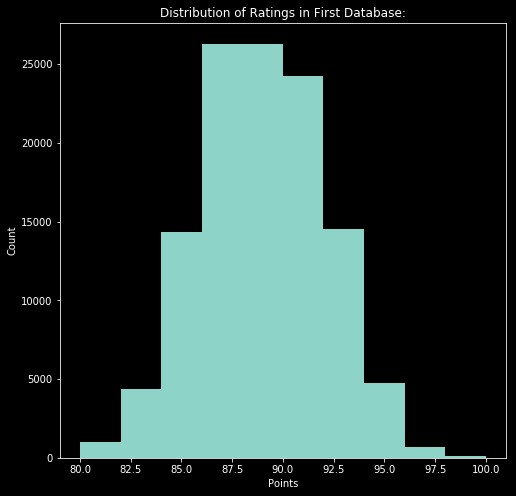

In [25]:
# winemag-data-130k-v2.json Points Rating distribution:
plt.hist(df0.points)
plt.title('Distribution of Ratings in First Database:')
plt.ylabel('Count')
plt.xlabel('Points')

plt.show()

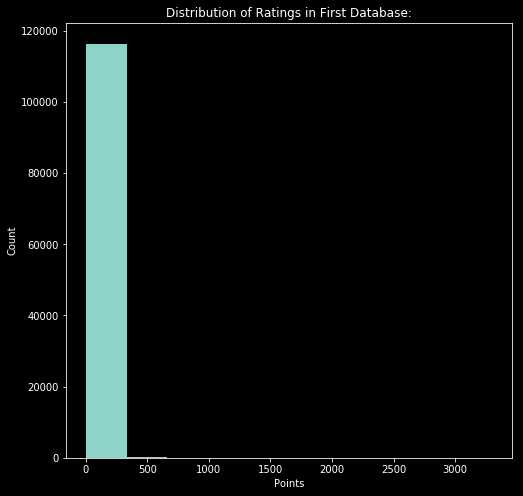

In [26]:
# winemag-data-130k-v2.json Price distribution:
plt.hist(df0.price)
plt.title('Distribution of Ratings in First Database:')
plt.ylabel('Count')
plt.xlabel('Points')

plt.show()

In [27]:
df0.head()

,country,description,designation,points,price,province,region_1,title,variety,winery,vintage
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,None,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,2011
2,US,"Tart and snappy, the flavors of lime flesh and...",None,87,14.0,Oregon,Willamette Valley,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm,2013
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian,2013
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks,2012
5,Spain,Blackberry and raspberry aromas show a typical...,Ars In Vitro,87,15.0,Northern Spain,Navarra,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem,2011


In [28]:
df0.points.describe()

count    116618.000000
mean         88.455298
std           3.044239
min          80.000000
25%          86.000000
50%          88.000000
75%          91.000000
max         100.000000
Name: points, dtype: float64

In [29]:
df0[df0['price'] > 1000]

,country,description,designation,points,price,province,region_1,title,variety,winery,vintage
1558,France,"A massive wine for Margaux, packed with tannin...",None,98,1900.0,Bordeaux,Margaux,Château Margaux 2009 Margaux,Bordeaux-style Red Blend,Château Margaux,2009
1566,France,"Such a generous and ripe wine, with a dark cor...",None,97,1100.0,Bordeaux,Pessac-Léognan,Château La Mission Haut-Brion 2009 Pessac-Léo...,Bordeaux-style Red Blend,Château La Mission Haut-Brion,2009
1571,France,"Solid, very structured, packed with dense and ...",None,96,1200.0,Bordeaux,Pessac-Léognan,Château Haut-Brion 2009 Pessac-Léognan,Bordeaux-style Red Blend,Château Haut-Brion,2009
1575,France,"The purest Cabernet Sauvignon fruit, with dark...",None,96,1300.0,Bordeaux,Pauillac,Château Mouton Rothschild 2009 Pauillac,Bordeaux-style Red Blend,Château Mouton Rothschild,2009
15840,France,The wine is a velvet glove in an iron fist. Th...,None,96,2500.0,Bordeaux,Pomerol,Château Pétrus 2014 Pomerol,Bordeaux-style Red Blend,Château Pétrus,2014
65352,France,This extravagantly perfumed wine has great jui...,None,97,2000.0,Bordeaux,Pomerol,Château Pétrus 2011 Pomerol,Bordeaux-style Red Blend,Château Pétrus,2011
80290,France,This ripe wine shows plenty of blackberry frui...,None,88,3300.0,Bordeaux,Médoc,Château les Ormes Sorbet 2013 Médoc,Bordeaux-style Red Blend,Château les Ormes Sorbet,2013
89478,Austria,"Wet earth, rain-wet stones, damp moss, wild sa...",Ried Loibenberg Smaragd,94,1100.0,Wachau,None,Emmerich Knoll 2013 Ried Loibenberg Smaragd Gr...,Grüner Veltliner,Emmerich Knoll,2013
98380,France,"A superb wine from a great year, this is power...",None,96,2500.0,Burgundy,La Romanée,Domaine du Comte Liger-Belair 2010 La Romanée,Pinot Noir,Domaine du Comte Liger-Belair,2010
111753,France,"Almost black in color, this stunning wine is g...",None,100,1500.0,Bordeaux,Pauillac,Château Lafite Rothschild 2010 Pauillac,Bordeaux-style Red Blend,Château Lafite Rothschild,2010


In [30]:
df = pd.DataFrame(df0[df0['price'] < 1000]).drop('title', 1)

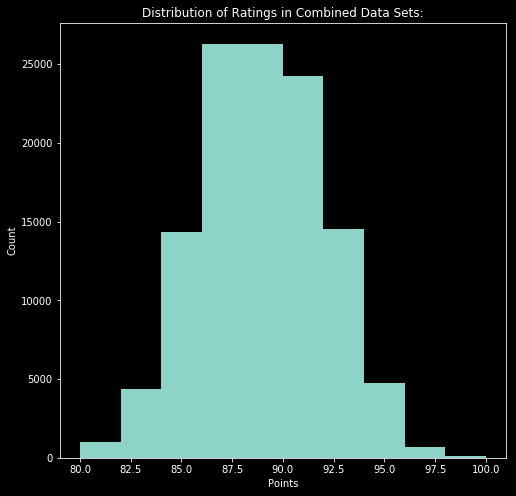

In [31]:
plt.hist(df.points)
plt.title('Distribution of Ratings in Combined Data Sets:')
plt.ylabel('Count')
plt.xlabel('Points')

plt.show()

In [32]:
df.points.describe()

count    116603.000000
mean         88.454388
std           3.043185
min          80.000000
25%          86.000000
50%          88.000000
75%          91.000000
max         100.000000
Name: points, dtype: float64

In [33]:
df['price'] = df['price'].apply(lambda x: float(x))

In [34]:
df['price'].describe()

count    116603.000000
mean         35.184421
std          35.197055
min           4.000000
25%          17.000000
50%          25.000000
75%          42.000000
max         973.000000
Name: price, dtype: float64

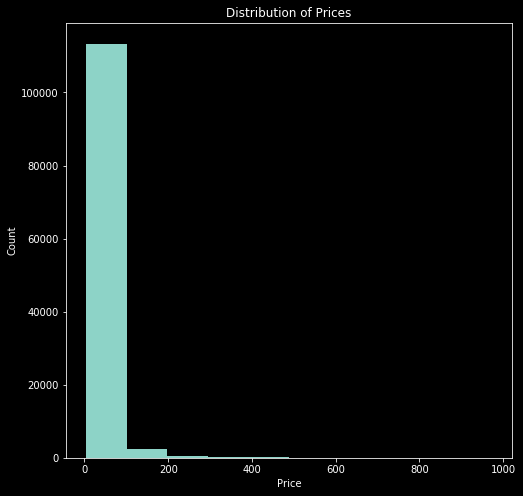

In [35]:
plt.hist(df['price'])
plt.title('Distribution of Prices')
plt.ylabel('Count')
plt.xlabel('Price')

plt.show()

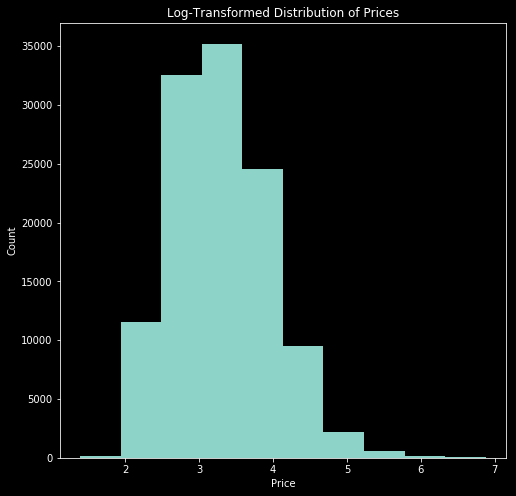

In [36]:
plt.hist(np.log(df['price']))
plt.title('Log-Transformed Distribution of Prices')
plt.ylabel('Count')
plt.xlabel('Price')

plt.show()

In [37]:
df.head()

,country,description,designation,points,price,province,region_1,variety,winery,vintage
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,None,Portuguese Red,Quinta dos Avidagos,2011
2,US,"Tart and snappy, the flavors of lime flesh and...",None,87,14.0,Oregon,Willamette Valley,Pinot Gris,Rainstorm,2013
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,Riesling,St. Julian,2013
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Pinot Noir,Sweet Cheeks,2012
5,Spain,Blackberry and raspberry aromas show a typical...,Ars In Vitro,87,15.0,Northern Spain,Navarra,Tempranillo-Merlot,Tandem,2011


# Feature Engineering/Selection:

In [38]:
features = pd.DataFrame(df)

In [39]:
features.head()

,country,description,designation,points,price,province,region_1,variety,winery,vintage
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,None,Portuguese Red,Quinta dos Avidagos,2011
2,US,"Tart and snappy, the flavors of lime flesh and...",None,87,14.0,Oregon,Willamette Valley,Pinot Gris,Rainstorm,2013
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,Riesling,St. Julian,2013
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Pinot Noir,Sweet Cheeks,2012
5,Spain,Blackberry and raspberry aromas show a typical...,Ars In Vitro,87,15.0,Northern Spain,Navarra,Tempranillo-Merlot,Tandem,2011


In [40]:
len(features)

116603

In [41]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 116603 entries, 1 to 129970
Data columns (total 10 columns):
country        116603 non-null object
description    116603 non-null object
designation    116603 non-null object
points         116603 non-null int64
price          116603 non-null float64
province       116603 non-null object
region_1       116603 non-null object
variety        116603 non-null object
winery         116603 non-null object
vintage        116603 non-null int64
dtypes: float64(1), int64(2), object(7)
memory usage: 9.8+ MB


## Price/Points-related features:

Our outcomes of interest in this model are price and points score; points are already normally distributed, but we need to perform a transformation on the data to get a normal "price" variable. A simple natural log transformation will do the trick.

We can use log price and points as target variables in regression modeling, but we'll need to split this data into bins if we're doing classification modeling.

In [42]:
features['logprice'] = np.log(features.price)

In [43]:
features['price'].describe()

count    116603.000000
mean         35.184421
std          35.197055
min           4.000000
25%          17.000000
50%          25.000000
75%          42.000000
max         973.000000
Name: price, dtype: float64

In [44]:
features['price'].median()

25.0

In [45]:
features['price'].mean()

35.18442064097836

In [46]:
features['logprice'].describe()

count    116603.000000
mean          3.317350
std           0.650529
min           1.386294
25%           2.833213
50%           3.218876
75%           3.737670
max           6.880384
Name: logprice, dtype: float64

In [47]:
np.log(features['price'].mean())

3.5606033892030347

In [48]:
np.e ** features['logprice'].mean()

27.587134478536008

In [49]:
# Create binary outcome for wine price:

features['thirty_or_more'] = np.where(features['price'] >= 30.0, 1, 0)

In [50]:
features['thirty_or_more'].value_counts()

0    65755
1    50848
Name: thirty_or_more, dtype: int64

In [51]:
# Function for Joint Plots showing R-squared value

def R_coeff(x, y):
    """Returns Pearson R coefficient for two variables."""
    return stats.pearsonr(x, y)[0]

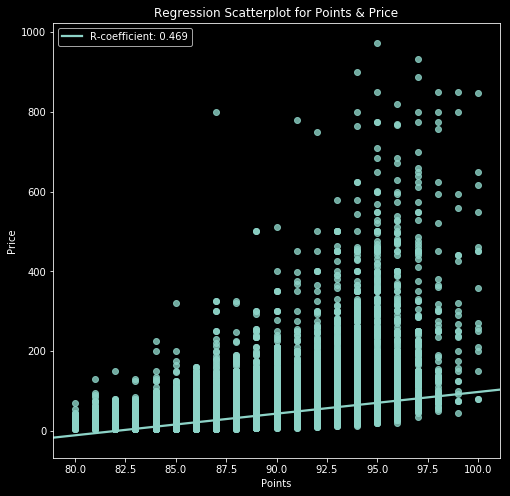

In [52]:
plt.rcParams['figure.figsize'] = 8, 8

sns.regplot(features.points, features.price)
plt.title('Regression Scatterplot for Points & Price')
plt.xlabel('Points')
plt.ylabel('Price')
plt.legend(['R-coefficient: '+str(R_coeff(features.points, features.price))[:5]])
plt.show()

In [53]:
# Create binary outcome for wine rating:

features['high_rating'] = features.points.apply(lambda x: 1 if x > 90 else 0)

In [54]:
features['high_rating'].value_counts()

0    86244
1    30359
Name: high_rating, dtype: int64

## Origin Feature Engineering:

In [55]:
len(features['country'].unique())

42

In [56]:
len(features['province'].unique())

415

In [57]:
len(features['region_1'].unique())

1193

In [58]:
len(features['winery'].unique())

15453

In [59]:
features['country'].value_counts()

US                        53287
France                    16350
Italy                     16085
Spain                      6057
Portugal                   4613
Chile                      4387
Argentina                  3714
Austria                    2760
Australia                  2224
Germany                    2102
New Zealand                1368
South Africa               1277
Israel                      482
Greece                      440
Canada                      253
Hungary                     142
Bulgaria                    141
Romania                     120
Uruguay                     108
Turkey                       90
Georgia                      81
Slovenia                     78
Mexico                       70
Croatia                      70
Moldova                      57
England                      55
Brazil                       38
Lebanon                      35
Morocco                      28
Peru                         16
Serbia                       12
Macedoni

In [60]:
# Review number of wines for each region, by country:

for country in features['country'].value_counts().index:
    print(country, '\n')
    print(features[features['country'] == country]['province'].value_counts().head(20), '\n')

US 

California           35434
Washington            8510
Oregon                5319
New York              2601
Virginia               731
Idaho                  187
Michigan               107
Texas                   90
Colorado                66
America                 56
New Mexico              41
Arizona                 34
Missouri                24
North Carolina          23
Pennsylvania            18
Ohio                    12
New Jersey               8
Washington-Oregon        6
Massachusetts            6
Nevada                   4
Name: province, dtype: int64 

France 

Bordeaux                3988
Burgundy                3052
Alsace                  1912
Loire Valley            1536
Southwest France        1330
Provence                1139
Rhône Valley            1037
Beaujolais               846
Languedoc-Roussillon     574
France Other             493
Champagne                443
Name: province, dtype: int64 

Italy 

Tuscany               5127
Piedmont              3058
Nor

Name: province, dtype: int64 

Czech Republic 

Moravia    11
Name: province, dtype: int64 

Cyprus 

Cyprus                3
Pafos                 3
Lemesos               1
Pitsilia Mountains    1
Commandaria           1
Kathikas              1
Name: province, dtype: int64 

India 

Nashik    9
Name: province, dtype: int64 

Switzerland 

Switzerland    3
Valais         2
Neuchâtel      1
Ticino         1
Name: province, dtype: int64 

Ukraine 

Ukraine    5
Name: province, dtype: int64 

Luxembourg 

Moselle Luxembourgeoise    3
Name: province, dtype: int64 

Bosnia and Herzegovina 

Mostar    2
Name: province, dtype: int64 

Armenia 

Armenia    2
Name: province, dtype: int64 

China 

China    1
Name: province, dtype: int64 

Slovakia 

Muzla    1
Name: province, dtype: int64 



"Country," "province," "region_1," and "winery" are hierarchical features; including all of them doesn't make sense because each is a subdivision of the last. For purposes of reining in collinearity and reducing the overall number of features while still maintaining breadth in location designations, we will use "province" and eschew the other categories. For clarity, we will add respective countries as prefixes to the "province" categories.

In [61]:
# For regions with fewer than 100 wines, sort into an "other" category for each country.

countrydict = {}

for country in features.country.unique():
    for province in features[features.country == country]['province'].unique():
        if len(features[features['province'] == province]) > 100:
            countrydict[province] = '{}: {}'.format(country, province)
        else:
            countrydict[province] = '{}: other'.format(country)

In [62]:
features['province'] = features['province'].replace(countrydict)

In [63]:
features.province.value_counts().head(40)

US: California                  35434
US: Washington                   8510
US: Oregon                       5319
Italy: Tuscany                   5127
France: Bordeaux                 3988
Spain: Northern Spain            3785
Argentina: Mendoza Province      3190
Italy: Piedmont                  3058
France: Burgundy                 3052
US: New York                     2601
Italy: Northeastern Italy        1937
France: Alsace                   1912
Italy: Veneto                    1767
Italy: Sicily & Sardinia         1547
France: Loire Valley             1536
France: Southwest France         1330
Australia: South Australia       1322
France: Provence                 1139
Portugal: Douro                  1132
Italy: Southern Italy            1121
Italy: Central Italy             1062
France: Rhône Valley             1037
Germany: Mosel                   1016
France: Beaujolais                846
Portugal: Alentejano              821
Spain: Catalonia                  820
Chile: Colch

## Descriptive Words:

In [64]:
features['designation'] = features.designation.apply(lambda x: unidecode.unidecode(x))

for feature in ['variety', 'description', 'designation', 'province']:
    # replace diacritics with ordinary ASCII
    features[feature] = features[feature].apply(lambda x: unidecode.unidecode(x))
    # replace '-' with ' '
    features[feature] = features[feature].str.replace('-', ' ')
    # replace punctuation with ''
    features[feature] = features[feature].str.replace(r'[^a-zA-Z\d\s:]', '')
    # make lower case
    features[feature] = features[feature].str.lower()

descriptors = features.description.str.cat(sep=' ').split()
varietalwords = features.variety.str.cat(sep=' ').split()
designations = features.designation.str.cat(sep=' ').split()
locations = features.province.str.cat(sep=' ').split()

In [65]:
features.head()

,country,description,designation,points,price,province,region_1,variety,winery,vintage,logprice,thirty_or_more,high_rating
1,Portugal,this is ripe and fruity a wine that is smooth ...,avidagos,87,15.0,portugal: douro,None,portuguese red,Quinta dos Avidagos,2011,2.708050,0,0
2,US,tart and snappy the flavors of lime flesh and ...,none,87,14.0,us: oregon,Willamette Valley,pinot gris,Rainstorm,2013,2.639057,0,0
3,US,pineapple rind lemon pith and orange blossom s...,reserve late harvest,87,13.0,us: michigan,Lake Michigan Shore,riesling,St. Julian,2013,2.564949,0,0
4,US,much like the regular bottling from 2012 this ...,vintners reserve wild child block,87,65.0,us: oregon,Willamette Valley,pinot noir,Sweet Cheeks,2012,4.174387,1,0
5,Spain,blackberry and raspberry aromas show a typical...,ars in vitro,87,15.0,spain: northern spain,Navarra,tempranillo merlot,Tandem,2011,2.708050,0,0


In [66]:
len(descriptors)

4824018

In [67]:
len(varietalwords)

197274

In [68]:
len(designations)

224154

In [69]:
len(locations)

264120

That's a lot of unique words in each column! To avoid problems with collinearity when modeling price/points, and to avoid tautological categorization, we will remove from the "descriptors" category any words that refer literally to a particular variety of wine, or to a specific place of origin. Exact matches for years of vintage will also be removed.

In [70]:
def matchstring(x, y):
    """Return 1 if word y is in string x, else return 0"""
    match = 0
    if type(y) == str:
        if y in x:
            match = 1
    elif type(y) == list:
        for item in y:
            if item in x:
                match = 1
    return match

In [71]:
allwords = pd.DataFrame(descriptors)[0].value_counts()

In [72]:
allwords.head(20)

and        316938
the        199196
a          160770
of         157266
with       108476
this       102698
is          84577
wine        67775
flavors     58073
in          57710
to          50489
it          49316
fruit       44847
its         43688
on          42259
aromas      36272
palate      35522
finish      32527
that        32312
acidity     29980
Name: 0, dtype: int64

### List of Redundant/Unimportant Words:

In [73]:
# Non-descriptive words:

stopwords = ['the', 'and', 'a', 'of', 'with', 'this', 'very',
             'is', 'in', 'it', 'to', 'its', 'on', 'that', 'more',
             'but', 'from', 'are', 'for', 'has', 'an', 'as',
             'by', 'now', 'shows', 'offers', 'wine', 'so',
             'through', 'up', 'or', 'not', 'be', 'out', 'all',
             'like', 'made', 'at', 'while', 'some', 'well', 'will',
             'you', 'your', 'was', 'then', 'how', 'once', 'although',
            'than', 'which', 'into', 'one', 'over', 'also']

# Redundant words (words containing other words, or contained by other words)

redundantwords = ['surprisingly', 'crus', 'sticky', 'underbrush', 'structured',
                 'let', 'often', '16', 'palate', 'promises', 'rocks', 'sugary',
                 'defined', 'highlights', 'gain', 'deal', '12', '13', 'used', 
                 'nuanced', 'based', 'entirely', 'there', 'here', 'lend',
                 'times', 'squeezed', 'amidst', 'cru', 'alongside', 'snappy',
                 'notes', 'present', 'rewarding', 'smoked', 'stemmy', 'ageworthy',
                 'youthful', 'brings', 'organically', 'waves', 'bubbles', 'producer',
                 'controlled', 'characteristics', 'tinged', 'initially', 'shines',
                 'characteristics', 'tinged', 'initially', 'shines', 'aromas',
                 'silky', 'beautifully', 'zesty', 'says', 'leafy', 'flavors',
                 'focused', 'salty', 'combines', 'straightforward', '2028', 'hefty',
                 'looking', 'coating', 'detail', 'charming', 'perfumed', 'petals',
                 'backdrop', 'known', 'flowers', 'everything', '2023', 'designated',
                 'additional', 'complexity', 'earthy', 'balanced', 'along', 'mouthfeel',
                 'herbal', 'cola', 'come', 'enough', 'just', 'thats', 'have', 'too', 'should',
                 'feels', 'hints']

In [74]:
# Descriptor words that match years of production are out, too:

yearnames = [str(x) for x in np.arange(1993, 2019)]

In [75]:
dropwords = stopwords + redundantwords + yearnames

In [76]:
allwords.drop(dropwords, inplace=True)

In [77]:
allwords = allwords.reset_index()

In [78]:
allwords

,index,0
0,fruit,44847
1,finish,32527
2,acidity,29980
3,tannins,27925
4,cherry,27447
5,drink,27137
6,black,26992
7,ripe,23806
8,red,19495
9,spice,17324


In [79]:
commondescriptors = allwords[allwords[0] > 3500]['index'].tolist()

In [80]:
print(commondescriptors, sep = ", ")  


['fruit', 'finish', 'acidity', 'tannins', 'cherry', 'drink', 'black', 'ripe', 'red', 'spice', 'oak', 'nose', 'berry', 'rich', 'dry', 'fresh', 'full', 'plum', 'blackberry', 'blend', 'soft', 'sweet', 'apple', 'dark', 'fruits', 'white', 'light', 'bodied', 'crisp', 'texture', 'vanilla', 'cabernet', 'citrus', 'pepper', 'bright', 'raspberry', 'juicy', 'green', 'good', 'lemon', 'chocolate', 'firm', 'fruity', 'peach', 'touch', 'dried', 'sauvignon', 'pear', 'years', 'spicy', 'character', 'structure', 'medium', 'fine', 'smooth', 'herb', 'tart', 'pinot', 'tannic', 'long', 'vineyard', 'currant', 'style', 'concentrated', 'wood', 'mouth', 'licorice', 'merlot', 'bit', 'note', 'mineral', 'flavor', 'lime', 'hint', 'still', 'syrah', 'orange', 'clean', 'theres', 'balance', 'give', 'toast', 'savory', 'age', 'leather', 'lead', 'opens', 'tobacco', 'creamy', 'slightly', 'dense', 'elegant', 'yet', 'delicious', 'aging', 'cassis', 'complex', 'easy', 'tight', 'wines', 'new', 'ready', 'herbs', 'great', 'chardonna

In [81]:
print(len(commondescriptors))

134


### Filtering Description Words:

To avoid collinearity between descriptions containing names of varietals, we are removing those words from the list of description words, with a few excpetions. The only word in common between province and description that appeared in the most frequent words list was "new."

In [82]:
# Create list of words that could lead to too much collinearity:

wordsincommon1 = []

for word in commondescriptors:
    if word in varietalwords:
        wordsincommon1.append(word)

In [83]:
# Some of these are innocuous, but many of them could contain clues as to the wine varietal.
# We don't want our predictor to parrot back results, so 'malbec' and 'grenache' have to go.

print(wordsincommon1, sep = ", ")  

['black', 'red', 'blend', 'white', 'cabernet', 'sauvignon', 'pinot', 'style', 'merlot', 'syrah', 'orange', 'chardonnay', 'melon', 'rose']


In [84]:
# Removed "apple," "orange," "melon," as these are more likely flavor descriptors.

wordsincommon1 = ['black', 'red', 'blend', 'white', 'cabernet',
                  'sauvignon', 'pinot', 'style', 'merlot',
                  'syrah', 'chardonnay', 'rose']

commondescriptors = list(set(commondescriptors) - set(wordsincommon1))

In [85]:
len(commondescriptors)

122

In [86]:
commondescriptors

['give',
 'dark',
 'high',
 'bit',
 'creamy',
 'finish',
 'wines',
 'juicy',
 'chocolate',
 'lime',
 'blackberry',
 'fine',
 'still',
 'structure',
 'almost',
 'pineapple',
 'complex',
 'young',
 'ready',
 'theres',
 'dense',
 'leather',
 'soft',
 'elegant',
 'note',
 'fruity',
 'sweet',
 'cherry',
 'yellow',
 'dry',
 'long',
 'smoky',
 'good',
 'strawberry',
 'orange',
 'medium',
 'age',
 'texture',
 'berry',
 'time',
 'herb',
 'cherries',
 'delicious',
 'new',
 'acidity',
 'bodied',
 'fruits',
 'crisp',
 'citrus',
 'hint',
 'licorice',
 'flavor',
 'delivers',
 'best',
 'yet',
 'spice',
 'richness',
 'freshness',
 'touch',
 'lively',
 'fruit',
 'character',
 'green',
 'opens',
 'currant',
 'mineral',
 'lemon',
 'vintage',
 'wild',
 'pear',
 'drink',
 'cassis',
 'melon',
 'tropical',
 'balance',
 'tobacco',
 'coffee',
 'vanilla',
 'firm',
 'slightly',
 'aging',
 'bright',
 'smooth',
 'spicy',
 'big',
 'great',
 'tannic',
 'tight',
 'easy',
 'rich',
 'honey',
 'grapefruit',
 'apple',
 '

In [87]:
features.description.str.len()

1         221
2         181
3         194
4         240
5         252
6         175
7         118
8         150
9         156
10        236
11        173
12        167
14        303
15        169
16        277
17        241
18        268
19        309
20        205
21        226
22        147
23        247
24        186
25        255
26        180
27        171
28        155
29        292
33        119
34        213
         ... 
129940    181
129941    236
129942    259
129943    227
129944    309
129945    378
129946    207
129947    242
129948    251
129949    285
129950    212
129951    207
129952    232
129953    175
129954    256
129955    253
129956    243
129957    354
129958    203
129959    283
129960    198
129961    285
129962    213
129963    337
129965    205
129966    222
129967    227
129968    220
129969    209
129970    163
Name: description, Length: 116603, dtype: int64

In [88]:
features['words_in_description'] = [len(x) for x in features.description.str.split()]
features['length_in_characters'] = features.description.apply(lambda x: len(x))

In [89]:
df.describe()

,points,price,vintage,logprice,thirty_or_more,high_rating
count,116603.000000,116603.000000,116603.000000,116603.000000,116603.000000,116603.000000
mean,88.454388,35.184421,2010.754252,3.317350,0.436078,0.260362
std,3.043185,35.197055,3.549848,0.650529,0.495899,0.438834
min,80.000000,4.000000,1993.000000,1.386294,0.000000,0.000000
25%,86.000000,17.000000,2009.000000,2.833213,0.000000,0.000000
50%,88.000000,25.000000,2011.000000,3.218876,0.000000,0.000000
75%,91.000000,42.000000,2013.000000,3.737670,1.000000,1.000000
max,100.000000,973.000000,2017.000000,6.880384,1.000000,1.000000


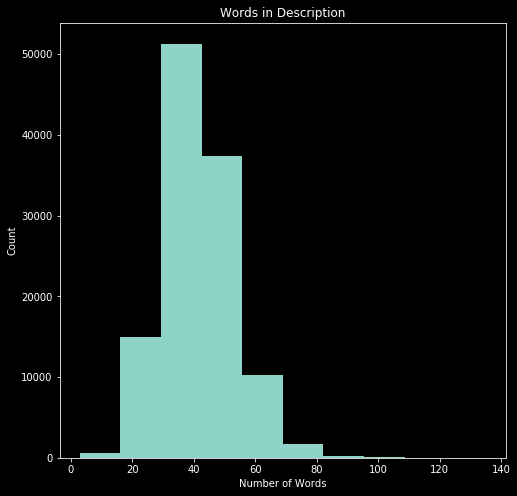

In [90]:
plt.hist(features['words_in_description'])
plt.title('Words in Description')
plt.xlabel('Number of Words')
plt.ylabel('Count')
plt.show()

### Grouping Features:

In [91]:
# Manually create binary features for descriptors:

for word in commondescriptors: 
    features[str('descriptor_' + word)] = features['description'].apply(lambda x: matchstring(x, word))

In [92]:
descriptorcolumns = []
for word in commondescriptors:
    descriptorcolumns.append('descriptor_' + word)

## General Types of Wine:

In [93]:
features['variety'].unique()

array(['portuguese red', 'pinot gris', 'riesling', 'pinot noir',
       'tempranillo merlot', 'frappato', 'gewurztraminer',
       'cabernet sauvignon', 'chardonnay', 'malbec', 'tempranillo blend',
       'meritage', 'red blend', 'white blend', 'merlot', 'nero davola',
       'chenin blanc', 'sauvignon blanc', 'viognier chardonnay',
       'primitivo', 'catarratto', 'gamay', 'inzolia', 'petit verdot',
       'monica', 'bordeaux style white blend', 'grillo', 'sangiovese',
       'cabernet franc', 'bordeaux style red blend', 'aglianico',
       'petite sirah', 'carmenere', 'albarino', 'petit manseng', 'rose',
       'zinfandel', 'vernaccia', 'rosato', 'gruner veltliner', 'viognier',
       'vermentino', 'grenache blanc', 'syrah', 'nebbiolo',
       'shiraz cabernet sauvignon', 'pinot blanc', 'alsace white blend',
       'barbera', 'rhone style red blend', 'portuguese white', 'graciano',
       'tannat cabernet', 'sauvignon', 'torrontes', 'prugnolo gentile',
       'g s m', 'verdejo', 'fu

In [94]:
#Manually-entered list of wine by general color and/or type, until less than 1% are unlabeled.

redlist = ['red', 'tinto', 'tinta', 'noir', 'rosso', 'nero', 'negro', 'merlot',
          'cabernet', 'syrah', 'sangiovese', 'malbec',
          'barbera', 'shiraz', 'grenache', 'g s m', 'gsm', 'bobal',
          'nebbiolo', 'chianti', 'amarone', 'lambrusco', 'barolo',
          'burgundy', 'beaujolais', 'rioja', 'garnacha', 'primitivo',
          'zinfandel', 'tempranillo', 'petite sirah', 'dolcetto',
          'verdot', 'aglianico', 'gamay', 'corvina rondinella molinara',
          'mourvedre', 'montepulciano', 'monastrell', 'touriga', 'sagrantino',
          'mencia', 'nerello', 'bonarda', 'tannat', 'lagrein', 'carignano',
          'carignan', 'cannonau', 'carmenere', 'graciano', 'claret',
          'prugnolo', 'frappato', 'cinsault', 'charbono', 'teroldego', 'prieto picudo',
          'corvina', 'schiava', 'negrette', 'blaufrankisch', 'gaglioppo', 'raboso',
          'pinotage', 'lemberger', 'norton', 'trepat', 'brachetto', 'counoise',
          'mondeuse', 'ruche', 'uva di troia', 'alicante', 'chambourcin',
          'perricone', 'hondarribi beltza', 'hondarrabi beltza', 'mataro',
          'maturana', 'duras', 'zweigelt', 'monica', 'cesanese daffile',
          'casavecchia', 'marzemino', 'susumaniello', 'ciliegiolo', 'agiorgitiko',
          'st laurent' ,'spatburgunder', 'xinomavro', 'saperavi', 'castelao',
          'baga', 'dornfelder', 'roter veltliner', 'trincadeira', 'plavac mali',
          'alfrocheiro', 'kalecik karasi', 'aragones', 'kekfrankos', 'teran',
          'feteasca neagra', 'refosco', 'aragonez', 'jaen', 'okuzgozu', 'mavrud', 
          'vranec', 'vranac', 'savatiano', 'sousao', 'souzao', 'trousseau',
          'bastardo', 'braucol', 'fer', 'valdiguie', 'carinena', 'durif', 'bogazkere',
          'pugnitello', 'bovale']

whitelist = ['white', 'bianco', 'blanc', 'blanco', 'blanca', 'gris', 'grigio', 'grillo',
            'muscat', 'moscato', 'chardonnay', 'viognier', 'gewurztraminer',
            'riesling', 'torrontes', 'semillon', 'chenin', 'marsanne', 'roussanne',
            'verdicchio', 'verdejo', 'albarino', 'vermentino', 'glera', 'garganega',
            'melon', 'turbiana', 'gruner veltliner', 'greco', 'moscatel', 'vernaccia',
            'trebbiano', 'manseng', 'viura', 'macabeo', 'fiano', 'cortese',
            'falanghina', 'godello', 'arneis', 'friulano', 'carricante', 'mantonico',
            'catarratto', 'verdelho', 'sylvaner', 'ribolla gialla', 'zibibbo',
            'xarel lo', 'pecorino', 'albana', 'palomino', 'insolia', 'jacquere',
            'inzolia', 'malvasia', 'muller thurgau', 'colombard', 'muscadelle',
            'moscadello', 'auxerrois', 'passerina', 'vignoles', 'savagnin', 'kerner',
            'aligote', 'traminer', 'vidal', 'picpoul', 'piquepoul', 'coda di volpe',
            'picolit', 'mauzac', 'durella', 'hondarrabi zuri', 'hondarribi zuri',
            'grechetto', 'verdeca', 'loin de loeil', 'chasselas', 'nosiola', 
            'traminette', 'rkatsiteli', 'alvarinho', 'arinto', 'assyritiko', 'furmint',
            'silvaner', 'weissburgunder', 'moschofilero', 'loureiro', 'fernao pires',
            'encruzado', 'scheurebe', 'muskateller', 'assyrtiko', 'assyrtico',
            'muskat ottonel', 'antao vaz', 'rotgipfler', 'roditis', 'rhoditis',
            'grauburgunder', 'bical', 'malagousia', 'zierfandler', 'siria', 'tocai', 
            'mavrodaphne', 'posip', 'muscadel', 'narince', 'avesso', 'aleatico',
            'verduzzo', 'morillon', 'grecanico', 'altesse', 'neuburger', 'edelzwicker',
            'vilana', 'cerceal', 'feteasca regala', 'kisi', 'symphony', 'robola',
            'rieslaner', 'malagouzia', 'veltliner', 'debit', 'timorasso', 'codega do larinho',
            'morio muskat']

roselist = ['rose', 'rosato', 'rosado']

sparklinglist = ['champagne', 'pinot meunier', 'sparkling', 'bical']

fortifiedlist = ['sherry', 'port', 'porto', 'madeira', 'vermouth', 'marsala',
                'commandaria', 'mistelle', 'pedro ximenez', 'tokaji', 'tokay',
                'bual', 'boal', 'mavrodaphne', 'mission']

features['type_blend'] = features['variety'].apply(lambda x: matchstring(x, 'blend'))
features['type_red'] = features['variety'].apply(lambda x: matchstring(x, redlist))
features['type_white'] = features['variety'].apply(lambda x: matchstring(x, whitelist))
features['type_rose'] = features['variety'].apply(lambda x: matchstring(x, roselist))
features['type_fortified'] = features['variety'].apply(lambda x: matchstring(x, fortifiedlist))
features['type_sparkling'] = features['variety'].apply(lambda x: matchstring(x, sparklinglist))

typelist = ['type_blend', 'type_red', 'type_white', 'type_rose', 'type_fortified', 'type_sparkling']


# 'Cabernet Sauvignon' is red but 'Sauvignon' by itself is white.
features.loc[features.variety == 'sauvignon', 'type_white'] = 1

In [95]:
# Check for typeless wines:

features['hastype'] = features['type_blend'] + features['type_red'] + features['type_white'] + features['type_rose'] + features['type_fortified'] + features['type_sparkling']

# "Meritage" just means the wine is a varietal from Bordeaux, which is home to both reds and whites.
# "Pallagrello" can be "nero" or "bianco."

features[features['hastype'] == 0]['variety'].value_counts()

meritage          258
pallagrello         9
viosinho            5
manzoni             5
rolle               4
marselan            4
emir                4
mazuelo             4
elbling             4
babic               4
nascetta            4
mansois             3
papaskarasi         3
azal                3
argaman             3
airen               3
poulsard            3
romorantin          3
marawi              3
jacquez             3
abouriou            3
muskat              3
treixadura          3
rivaner             3
nielluciu           3
pignoletto          3
erbaluce            3
sciaccerellu        3
canaiolo            3
grolleau            3
                 ... 
aidani              1
vidadillo           1
thrapsathiri        1
dafni               1
tintilia            1
cococciola          1
meseguera           1
pignolo             1
premsal             1
gros plant          1
ryzlink rynsky      1
prunelard           1
picapoll            1
karasakiz           1
kotsifali 

In [96]:
# Create binary features:

for general_type in typelist:
    print(general_type, ': ', len(features[features[general_type] == 1])/len(features))
    
print('type not assigned: ', len(features[features['hastype'] == 0])/len(features))

type_blend :  0.1743179849575054
type_red :  0.6241263089285868
type_white :  0.33006869463049837
type_rose :  0.02941605276022058
type_fortified :  0.03040230525801223
type_sparkling :  0.011449105083059612
type not assigned:  0.004571065924547396


### Exceptions:

"Meritage" doesn't necessarily indicate that the wine is white or red, only that it's a bordeaux grape varietal. Pinot meunier is a champagne grape. "Pallagrello" can be either "nero" or "bianco."

In [97]:
features[features['variety'] == 'maturana']

,country,description,designation,points,price,province,region_1,variety,winery,vintage,...,descriptor_pepper,descriptor_savory,descriptor_light,type_blend,type_red,type_white,type_rose,type_fortified,type_sparkling,hastype
3210,Spain,this unusual varietal wine hits with a giant w...,inspiracion,88,45.0,spain: northern spain,Rioja,maturana,Bodegas Valdemar,2005,...,1,0,0,0,1,0,0,0,0,1
43986,Spain,all indigenous grapes are welcomed by our tast...,ad libitum,82,40.0,spain: northern spain,Rioja,maturana,Juan Carlos Sancha,2008,...,0,0,0,0,1,0,0,0,0,1
54452,Spain,on first sniff you may want to head for the hi...,coleccion vivanco parcelas,87,105.0,spain: northern spain,Rioja,maturana,Dinastía Vivanco,2010,...,1,0,0,0,1,0,0,0,0,1
85559,Spain,dont be shocked by this wines saucy herbal nos...,varietales,87,20.0,spain: northern spain,Rioja,maturana,Baron De Ley,2010,...,1,0,0,0,1,0,0,0,0,1
98062,Spain,judged against more familiar varietal wines th...,coleccion vivanco parcelas,87,90.0,spain: northern spain,Rioja,maturana,Dinastía Vivanco,2009,...,0,0,0,0,1,0,0,0,0,1
127409,Spain,with dry spicy leafy aromas this is pure varie...,inspiracion,88,45.0,spain: northern spain,Rioja,maturana,Bodegas Valdemar,2008,...,0,0,0,0,1,0,0,0,0,1


## Correcting outliers:

In [98]:
# Set specific wines to correct type

features.loc[features.variety == 'grenache blanc', 'type_red'] = 0
features.loc[features.variety == 'shiraz viognier', 'type_white'] = 0
features.loc[features.variety == 'garnacha blanca', 'type_red'] = 0
features.loc[features.variety == 'syrah viognier', 'type_white'] = 0
features.loc[features.variety == 'tempranillo blanco', 'type_white'] = 0
features.loc[features.variety == 'pinot blanc pinot noir', ['type_red', 'type_white', 'type_rose']] = 0, 0, 1
features.loc[features.variety == 'roussanne grenache blanc', 'type_red'] = 0
features.loc[features.variety == 'grenache gris', 'type_red'] = 0
features.loc[features.variety == 'syrah grenache viognier', 'type_white'] = 0
features.loc[features.variety == 'shiraz roussanne', 'type_white'] = 0

In [99]:
topvarietals = features['variety'].value_counts().head(40).index.tolist()

In [100]:
topvarietals

['pinot noir',
 'chardonnay',
 'cabernet sauvignon',
 'red blend',
 'bordeaux style red blend',
 'riesling',
 'sauvignon blanc',
 'syrah',
 'rose',
 'merlot',
 'zinfandel',
 'malbec',
 'sangiovese',
 'nebbiolo',
 'portuguese red',
 'white blend',
 'tempranillo',
 'rhone style red blend',
 'pinot gris',
 'cabernet franc',
 'gruner veltliner',
 'pinot grigio',
 'viognier',
 'portuguese white',
 'gewurztraminer',
 'sparkling blend',
 'gamay',
 'shiraz',
 'petite sirah',
 'bordeaux style white blend',
 'grenache',
 'barbera',
 'sangiovese grosso',
 'tempranillo blend',
 'carmenere',
 'chenin blanc',
 'corvina rondinella molinara',
 'albarino',
 'rhone style white blend',
 'champagne blend']

In [101]:
features['varietal_other_red'] = np.where((~features['variety'].isin(topvarietals) & (features['type_red'] == 1)), 1, 0)
features['varietal_other_white'] = np.where((~features['variety'].isin(topvarietals) & (features['type_white'] == 1)), 1, 0)
features['varietal_other_rose'] = np.where((~features['variety'].isin(topvarietals) & (features['type_rose'] == 1)), 1, 0)
features['varietal_other_sparkling'] = np.where((~features['variety'].isin(topvarietals) & (features['type_sparkling'] == 1)), 1, 0)
features['varietal_other_fortified'] = np.where((~features['variety'].isin(topvarietals) & (features['type_fortified'] == 1)), 1, 0)

In [102]:
features.variety.value_counts()

pinot noir                    12643
chardonnay                    10813
cabernet sauvignon             9329
red blend                      8244
bordeaux style red blend       5312
riesling                       4942
sauvignon blanc                4757
syrah                          4080
rose                           3224
merlot                         3044
zinfandel                      2690
malbec                         2584
sangiovese                     2376
nebbiolo                       2331
portuguese red                 2191
white blend                    2060
tempranillo                    1784
rhone style red blend          1394
pinot gris                     1382
cabernet franc                 1297
gruner veltliner               1139
pinot grigio                    989
viognier                        983
portuguese white                979
gewurztraminer                  952
sparkling blend                 859
gamay                           832
shiraz                      

In [103]:
print(len(features[features['variety'].isin(topvarietals)]))
print(len(features[~features['variety'].isin(topvarietals)]))

100777
15826


In [104]:
# Create binary features:

for varietal in topvarietals: 
    features[str('varietal_' + varietal)] = features['variety'].apply(lambda x: matchstring(x, varietal))

In [105]:
varietalcolumns = []

# Append top varietals list to include general categories.
# All wines with an assigned type are accounted for.
# Only 0.457% of wines do not have an assigned type.

topvarietals = topvarietals + ['other_red', 'other_white', 'other_rose',
                              'other_sparkling', 'other_fortified']

for varietal in topvarietals:
    varietalcolumns.append('varietal_' + varietal)

In [106]:
varietalcolumns

['varietal_pinot noir',
 'varietal_chardonnay',
 'varietal_cabernet sauvignon',
 'varietal_red blend',
 'varietal_bordeaux style red blend',
 'varietal_riesling',
 'varietal_sauvignon blanc',
 'varietal_syrah',
 'varietal_rose',
 'varietal_merlot',
 'varietal_zinfandel',
 'varietal_malbec',
 'varietal_sangiovese',
 'varietal_nebbiolo',
 'varietal_portuguese red',
 'varietal_white blend',
 'varietal_tempranillo',
 'varietal_rhone style red blend',
 'varietal_pinot gris',
 'varietal_cabernet franc',
 'varietal_gruner veltliner',
 'varietal_pinot grigio',
 'varietal_viognier',
 'varietal_portuguese white',
 'varietal_gewurztraminer',
 'varietal_sparkling blend',
 'varietal_gamay',
 'varietal_shiraz',
 'varietal_petite sirah',
 'varietal_bordeaux style white blend',
 'varietal_grenache',
 'varietal_barbera',
 'varietal_sangiovese grosso',
 'varietal_tempranillo blend',
 'varietal_carmenere',
 'varietal_chenin blanc',
 'varietal_corvina rondinella molinara',
 'varietal_albarino',
 'varietal

In [107]:
features

,country,description,designation,points,price,province,region_1,variety,winery,vintage,...,varietal_grenache,varietal_barbera,varietal_sangiovese grosso,varietal_tempranillo blend,varietal_carmenere,varietal_chenin blanc,varietal_corvina rondinella molinara,varietal_albarino,varietal_rhone style white blend,varietal_champagne blend
1,Portugal,this is ripe and fruity a wine that is smooth ...,avidagos,87,15.0,portugal: douro,None,portuguese red,Quinta dos Avidagos,2011,...,0,0,0,0,0,0,0,0,0,0
2,US,tart and snappy the flavors of lime flesh and ...,none,87,14.0,us: oregon,Willamette Valley,pinot gris,Rainstorm,2013,...,0,0,0,0,0,0,0,0,0,0
3,US,pineapple rind lemon pith and orange blossom s...,reserve late harvest,87,13.0,us: michigan,Lake Michigan Shore,riesling,St. Julian,2013,...,0,0,0,0,0,0,0,0,0,0
4,US,much like the regular bottling from 2012 this ...,vintners reserve wild child block,87,65.0,us: oregon,Willamette Valley,pinot noir,Sweet Cheeks,2012,...,0,0,0,0,0,0,0,0,0,0
5,Spain,blackberry and raspberry aromas show a typical...,ars in vitro,87,15.0,spain: northern spain,Navarra,tempranillo merlot,Tandem,2011,...,0,0,0,0,0,0,0,0,0,0
6,Italy,heres a bright informal red that opens with ar...,belsito,87,16.0,italy: sicily sardinia,Vittoria,frappato,Terre di Giurfo,2013,...,0,0,0,0,0,0,0,0,0,0
7,France,this dry and restrained wine offers spice in p...,none,87,24.0,france: alsace,Alsace,gewurztraminer,Trimbach,2012,...,0,0,0,0,0,0,0,0,0,0
8,Germany,savory dried thyme notes accent sunnier flavor...,shine,87,12.0,germany: rheinhessen,None,gewurztraminer,Heinz Eifel,2013,...,0,0,0,0,0,0,0,0,0,0
9,France,this has great depth of flavor with its fresh ...,les natures,87,27.0,france: alsace,Alsace,pinot gris,Jean-Baptiste Adam,2012,...,0,0,0,0,0,0,0,0,0,0
10,US,soft supple plum envelopes an oaky structure i...,mountain cuvee,87,19.0,us: california,Napa Valley,cabernet sauvignon,Kirkland Signature,2011,...,0,0,0,0,0,0,0,0,0,0


## Designation:

This is a grab-bag of adjectives. Some of these denote place of origin, some of them are merely descriptions given to the wine by the winemaker. The usefulness of this variable may be somewhat limited. However, certain terms in this column indicate that the winemaker is presenting the wine as a product of superior quality, such as "reserve," "premier," "select," and "grand" (and of course, their French, Italian, German, and Portuguese translations). We will create a binary feature indicating whether the wine has been labeled with one of these terms of excellence, and see if there is in fact a correlation between a winemaker saying a wine is excellent, and it earning an excellent review.

We can also see that there is mention here of red, white, and rose varieties, so we can use this to override our classification for the "type" features if any wines have been mislabeled.

In [108]:
pd.DataFrame(designations)[0].value_counts().head(20)

none         34453
vineyard     12069
reserve       5414
estate        5161
reserva       3495
de            3399
la            1945
cuvee         1936
cru           1722
riserva       1600
the           1558
les           1459
grown         1389
brut          1220
grand         1212
dry           1089
ranch         1049
rose          1019
premier       1004
vineyards      981
Name: 0, dtype: int64

In [109]:
designation_excellent = ['reserve', 'riserva', 'reserva', 'gran',
                'grand', 'grande', 'premier', 'select', 'seleccion', 'selection',
                'signature', 'private', 'limited']

In [110]:
features['reserve'] = features['designation'].apply(lambda x: matchstring(x, designation_excellent))

In [111]:
features['reserve'].value_counts()

0    101414
1     15189
Name: reserve, dtype: int64

## Further EDA:

Now that we have a clearer picture of the categories we want to use to classify wines, let's have a closer look at relationships between some of the features we've created:

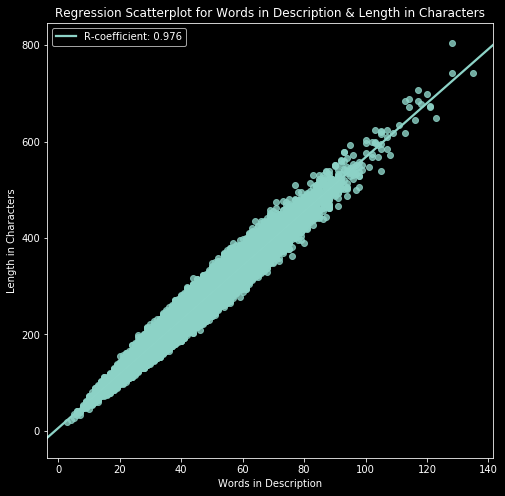

In [112]:
plt.rcParams['figure.figsize'] = 8, 8

sns.regplot(features['words_in_description'], features['length_in_characters'])
plt.title('Regression Scatterplot for Words in Description & Length in Characters')
plt.xlabel('Words in Description')
plt.ylabel('Length in Characters')
plt.legend(['R-coefficient: '+str(R_coeff(features.words_in_description, features.length_in_characters))[:5]])
plt.show()

We don't need to use both number of characters and number of words as features; they are highly collinear. We'll use 'words_in_description' because it's more indicative of a longer review in terms of sentence length.

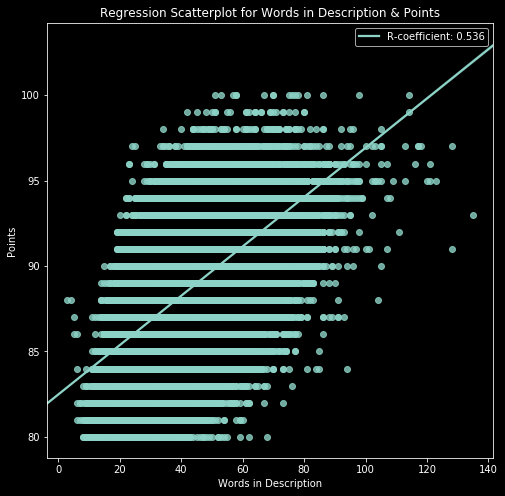

In [113]:
plt.rcParams['figure.figsize'] = 8, 8

sns.regplot(features['words_in_description'], features['points'])
plt.title('Regression Scatterplot for Words in Description & Points')
plt.xlabel('Words in Description')
plt.ylabel('Points')
plt.legend(['R-coefficient: '+str(R_coeff(features.words_in_description, features.points))[:5]])
plt.show()

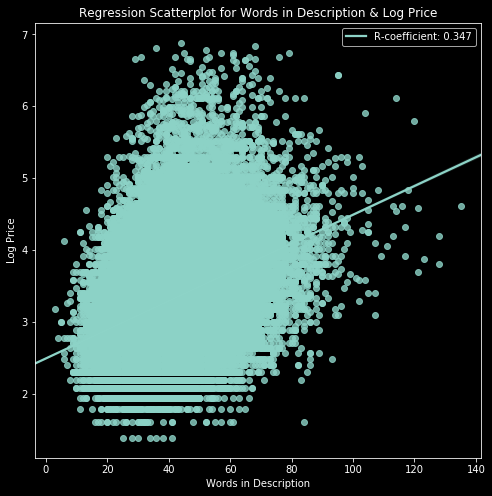

In [114]:
plt.rcParams['figure.figsize'] = 8, 8

sns.regplot(features['words_in_description'], features['logprice'])
plt.title('Regression Scatterplot for Words in Description & Log Price')
plt.xlabel('Words in Description')
plt.ylabel('Log Price')
plt.legend(['R-coefficient: '+str(R_coeff(features.words_in_description, features.logprice))[:5]])
plt.show()

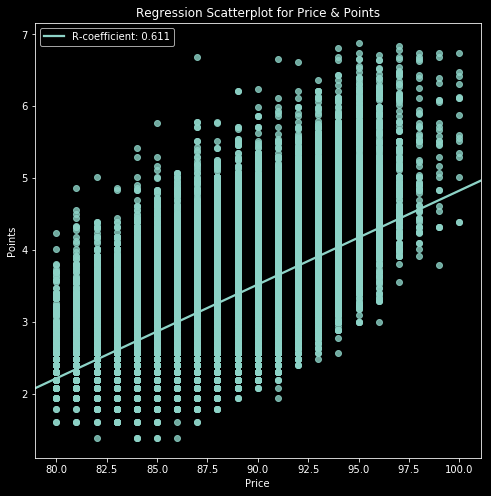

In [115]:
plt.rcParams['figure.figsize'] = 8, 8

sns.regplot(features['points'], features['logprice'])
plt.title('Regression Scatterplot for Price & Points')
plt.xlabel('Price')
plt.ylabel('Points')
plt.legend(['R-coefficient: '+str(R_coeff(features.points, features.logprice))[:5]])
plt.show()

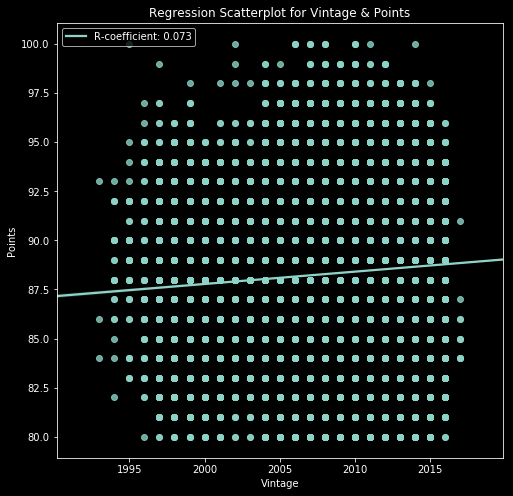

In [116]:
plt.rcParams['figure.figsize'] = 8, 8

sns.regplot(features['vintage'], features['points'])
plt.title('Regression Scatterplot for Vintage & Points')
plt.xlabel('Vintage')
plt.ylabel('Points')
plt.legend(['R-coefficient: '+str(R_coeff(features.vintage, features.points))[:5]])
plt.show()

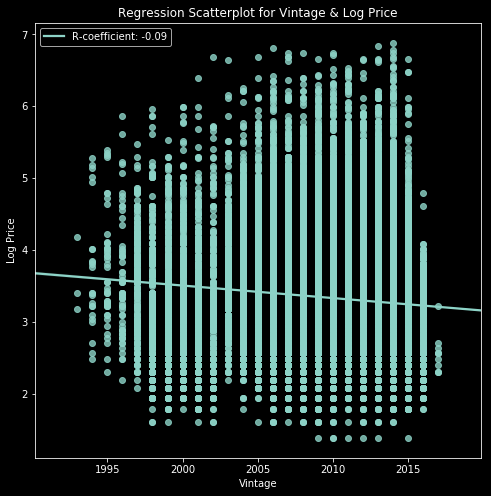

In [117]:
plt.rcParams['figure.figsize'] = 8, 8

sns.regplot(features['vintage'], features['logprice'])
plt.title('Regression Scatterplot for Vintage & Log Price')
plt.xlabel('Vintage')
plt.ylabel('Log Price')
plt.legend(['R-coefficient: '+str(R_coeff(features.vintage, features.logprice))[:5]])
plt.show()

In [118]:
stats.pearsonr(features.vintage, features.logprice)

(-0.09510833010220149, 2.0754483687769095e-232)

In [119]:
stats.pearsonr(features.vintage, features.points)

(0.07321693288830892, 2.552612652694807e-138)

We can see that there is a strong positive correlation between words in the description and both log-transformed price and points. Log-transformed price and points themselves are also positively correlated. There is a weak positive correlation for vintage and points, and a weak negative correlation between vintage and log-transformed price. This probably indicates that the price of wine is determined by rarity (unopened older bottles being more scarce) as well as overall quality.

### Highest-Rated Wine Varieties:

In [120]:
features[features['variety'].isin(topvarietals)].groupby('variety').mean().sort_values(by='points', ascending=False)

,points,price,vintage,logprice,thirty_or_more,high_rating,words_in_description,length_in_characters,descriptor_give,descriptor_dark,...,varietal_barbera,varietal_sangiovese grosso,varietal_tempranillo blend,varietal_carmenere,varietal_chenin blanc,varietal_corvina rondinella molinara,varietal_albarino,varietal_rhone style white blend,varietal_champagne blend,reserve
variety,,,,,,,,,,,,,,,,,,,,,
champagne blend,91.638821,98.651106,2004.095823,4.345793,0.894349,0.702703,46.132678,258.321867,0.125307,0.002457,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.176904
sangiovese grosso,90.801358,65.634975,2006.803056,4.049777,0.881154,0.556876,41.859083,246.176570,0.100170,0.268251,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.205433
nebbiolo,90.331188,65.609610,2009.968683,4.048969,0.919348,0.453024,42.969541,257.752038,0.096954,0.187473,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.093522
gruner veltliner,90.014047,26.823529,2012.861282,3.165543,0.285338,0.410009,40.267779,231.863038,0.083406,0.005268,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.198420
sparkling blend,89.457509,40.807916,2009.472643,3.569238,0.657742,0.344587,43.417928,251.025611,0.046566,0.010477,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.235157
riesling,89.449818,32.026103,2011.783286,3.210063,0.325172,0.347025,42.123027,246.831849,0.040672,0.010117,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.123027
pinot noir,89.425057,47.258562,2011.168077,3.686754,0.736771,0.405046,43.451633,249.350708,0.076169,0.103298,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.122597
syrah,89.296814,39.154167,2010.038725,3.520753,0.640931,0.389706,43.486765,250.933578,0.056863,0.171324,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.104412
rhone style red blend,89.149211,34.995696,2010.266858,3.389264,0.522238,0.352224,46.153515,264.469871,0.050215,0.150646,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.063128


### Most Expensive Wine Varieties:

In [121]:
features[features['variety'].isin(topvarietals)].groupby('variety').mean().sort_values(by='price', ascending=False)

,points,price,vintage,logprice,thirty_or_more,high_rating,words_in_description,length_in_characters,descriptor_give,descriptor_dark,...,varietal_barbera,varietal_sangiovese grosso,varietal_tempranillo blend,varietal_carmenere,varietal_chenin blanc,varietal_corvina rondinella molinara,varietal_albarino,varietal_rhone style white blend,varietal_champagne blend,reserve
variety,,,,,,,,,,,,,,,,,,,,,
champagne blend,91.638821,98.651106,2004.095823,4.345793,0.894349,0.702703,46.132678,258.321867,0.125307,0.002457,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.176904
sangiovese grosso,90.801358,65.634975,2006.803056,4.049777,0.881154,0.556876,41.859083,246.176570,0.100170,0.268251,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.205433
nebbiolo,90.331188,65.609610,2009.968683,4.048969,0.919348,0.453024,42.969541,257.752038,0.096954,0.187473,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.093522
cabernet sauvignon,88.617537,47.972237,2009.629006,3.581547,0.602959,0.305392,42.604352,244.706935,0.068818,0.142137,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.170436
corvina rondinella molinara,88.495968,47.907258,2006.951613,3.592306,0.570565,0.225806,38.243952,223.012097,0.050403,0.179435,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.046371
pinot noir,89.425057,47.258562,2011.168077,3.686754,0.736771,0.405046,43.451633,249.350708,0.076169,0.103298,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.122597
sangiovese,88.614899,45.294192,2009.644781,3.569081,0.563973,0.229798,40.839646,243.609848,0.063131,0.164141,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.242845
bordeaux style red blend,88.786709,44.266943,2010.858245,3.485382,0.525414,0.298569,42.934676,242.506589,0.133660,0.152861,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.070407
shiraz,89.089109,41.965347,2008.272277,3.343247,0.422030,0.337871,44.100248,252.777228,0.054455,0.162129,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.108911


## Features to be Dropped:

In [122]:
features2 = pd.get_dummies(features.drop(['length_in_characters', 'description', 'designation', 'country',
                    'region_1', 'winery', 'variety', 'hastype', 'price']+typelist, 1))

# Collinearity Reduction:

Before we build a predictive model, we will look at correlations between our features, and try to minimize collinearity between description features.

In [123]:
targets = ['points', 'high_rating', 'logprice', 'thirty_or_more']

In [124]:
corr = pd.DataFrame(features2.drop(targets, 1).corr())
corr

,vintage,words_in_description,descriptor_give,descriptor_dark,descriptor_high,descriptor_bit,descriptor_creamy,descriptor_finish,descriptor_wines,descriptor_juicy,...,province_ukraine: other,province_uruguay: other,province_us: california,province_us: idaho,province_us: michigan,province_us: new york,province_us: oregon,province_us: other,province_us: virginia,province_us: washington
vintage,1.000000,-0.085289,0.021494,-0.020827,-0.014365,-0.032686,-0.012226,0.005018,-0.050555,0.085310,...,0.001560,0.015212,-0.040400,0.002835,0.012949,0.020109,0.038026,-0.007464,0.015110,0.000867
words_in_description,-0.085289,1.000000,0.070020,0.115834,0.068660,0.030078,0.006647,0.086378,0.111596,0.022260,...,-0.004502,0.005135,0.013345,-0.031767,0.009052,-0.009662,0.033271,-0.015776,-0.006829,0.000514
descriptor_give,0.021494,0.070020,1.000000,-0.005237,0.010083,-0.002937,-0.005412,-0.066589,0.003797,0.021138,...,-0.001845,-0.005338,-0.022990,-0.006365,0.002313,-0.033212,-0.020024,0.000412,0.001766,-0.043684
descriptor_dark,-0.020827,0.115834,-0.005237,1.000000,0.002870,-0.000876,-0.035928,-0.002897,0.010039,0.013402,...,-0.002116,0.004616,-0.002341,-0.003427,0.004729,-0.031537,-0.028354,0.010743,0.012217,0.044347
descriptor_high,-0.014365,0.068660,0.010083,0.002870,1.000000,-0.003345,-0.014069,0.013228,0.022325,-0.019668,...,-0.001472,0.003698,0.053086,-0.003999,-0.006812,-0.010063,0.061713,-0.001470,-0.001600,0.048511
descriptor_bit,-0.032686,0.030078,-0.002937,-0.000876,-0.003345,1.000000,-0.012993,0.092179,-0.007850,-0.036291,...,-0.002028,0.003543,-0.034002,0.010345,0.007657,0.012214,0.038785,0.003215,0.003477,0.026189
descriptor_creamy,-0.012226,0.006647,-0.005412,-0.035928,-0.014069,-0.012993,1.000000,0.034595,0.008372,-0.023009,...,0.005296,-0.003398,-0.037245,-0.007150,-0.001919,-0.010131,-0.024918,-0.009044,-0.006404,-0.014856
descriptor_finish,0.005018,0.086378,-0.066589,-0.002897,0.013228,0.092179,0.034595,1.000000,-0.011897,-0.017320,...,0.006742,0.037757,-0.143271,-0.005883,0.001082,0.084323,0.002292,0.017568,0.031038,-0.014453
descriptor_wines,-0.050555,0.111596,0.003797,0.010039,0.022325,-0.007850,0.008372,-0.011897,1.000000,-0.019459,...,-0.001269,0.001646,-0.015943,-0.002030,-0.002841,-0.017148,0.004281,-0.004257,-0.006086,-0.006895
descriptor_juicy,0.085310,0.022260,0.021138,0.013402,-0.019668,-0.036291,-0.023009,-0.017320,-0.019459,1.000000,...,-0.001861,-0.005437,-0.078147,-0.008945,0.020469,0.018026,-0.028057,-0.001534,-0.003979,-0.049649


In [125]:
highcorr = []

for column in corr:
    if corr[column].sort_values().tolist()[-2] > 0.5:
        highcorr.append(column)

In [126]:
highcorr

['varietal_other_fortified',
 'varietal_red blend',
 'varietal_bordeaux style red blend',
 'varietal_sangiovese',
 'varietal_nebbiolo',
 'varietal_tempranillo',
 'varietal_gamay',
 'varietal_corvina rondinella molinara',
 'varietal_albarino',
 'varietal_champagne blend',
 'province_france: beaujolais',
 'province_france: bordeaux',
 'province_france: champagne',
 'province_italy: piedmont',
 'province_italy: tuscany',
 'province_italy: veneto',
 'province_portugal: port',
 'province_spain: galicia',
 'province_spain: northern spain']

In [127]:
corr = features2[highcorr].corr()

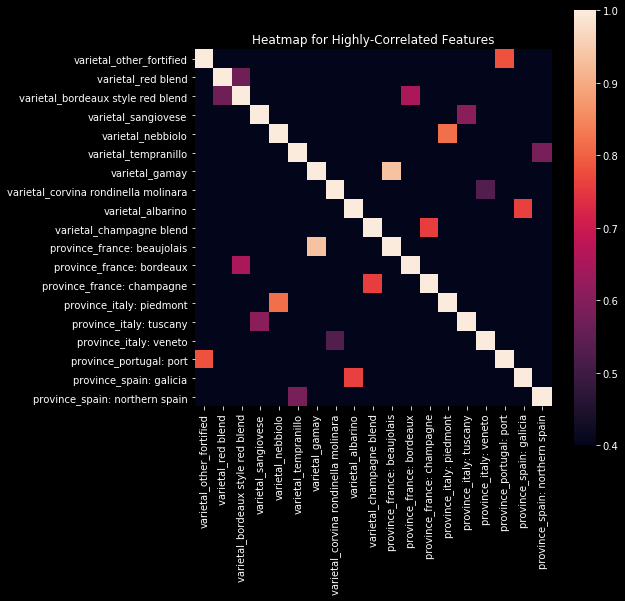

In [128]:
plt.rcParams['figure.figsize'] = 8, 8
sns.heatmap(corr, vmin=0.4, square=True)
plt.title('Heatmap for Highly-Correlated Features')
plt.show()

At this stage, correlations between descriptor words were picked out visually using the heatmap, then different forms of the words were added to the list in subsection 2.1.1 recursively. For example, if there was a hotspot of correlation for the words "nuance" and "nuanced," "nuanced" would be removed from features as the matching function we are using would catch both forms of the word.

This process could be streamlined considerably with the use of lemmatization through NLP, but here, we did it the hard way.

There is also some collinearity here between provinces and varietals with protected designation of origin status (PDO), as well as other wines commonly produced in specific regions. For instance, a wine can only be labeled "Bordeaux" if it's from the Bordeaux region of France, otherwise the same variety of grape would be labeled "Meritage." Similarly, Gamay grapes are used to make wine in Beaujolais, France, and Sangiovese is most commonly produced in Tuscany, Italy. Becuase this is only for a few categories, we will ignore this for now, although further models could implement more stringent filters at this stage.

# Dimensionality Reduction:

Here we use PCA to help determine the appropriate number of inputs to our models.

In [129]:
n_features = 40
sklearn_pca = PCA(n_components=n_features)

## PCA with StandardScaler:

In [130]:
features_pca = features2.drop(targets, 1)

X = StandardScaler(with_mean=False).fit_transform(features_pca)

Xt = X.T
Cx = np.cov(Xt)

# Calculating eigenvalues and eigenvectors.
eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)

# Inspecting the eigenvalues and eigenvectors.
for i in range(len(eig_val_cov)):
    eigvec_cov = eig_vec_cov[:, i].reshape(1, len(features2.drop(targets, 1).columns)).T

Y_sklearn = sklearn_pca.fit_transform(X)

print(
    '\nThe percentage of total variance in the dataset explained by each',
    'component from Sklearn PCA.\n',
    sklearn_pca.explained_variance_ratio_, '\nTotal explained variance:\n',
    sum(sklearn_pca.explained_variance_ratio_)
)


The percentage of total variance in the dataset explained by each component from Sklearn PCA.
 [0.01832747 0.01425166 0.01110713 0.0094149  0.00870036 0.00810066
 0.00794006 0.00736356 0.00712366 0.00704988 0.00692926 0.00678004
 0.00664829 0.00644847 0.00628956 0.00621723 0.00606964 0.00603585
 0.00578287 0.00577141 0.00562427 0.00540667 0.00532502 0.00529542
 0.00520071 0.00500313 0.00497403 0.00488483 0.00476495 0.00474569
 0.00455326 0.00448639 0.00440728 0.00439104 0.00437222 0.0042695
 0.00413535 0.0040606  0.00404443 0.00393054] 
Total explained variance:
 0.25622731578565205


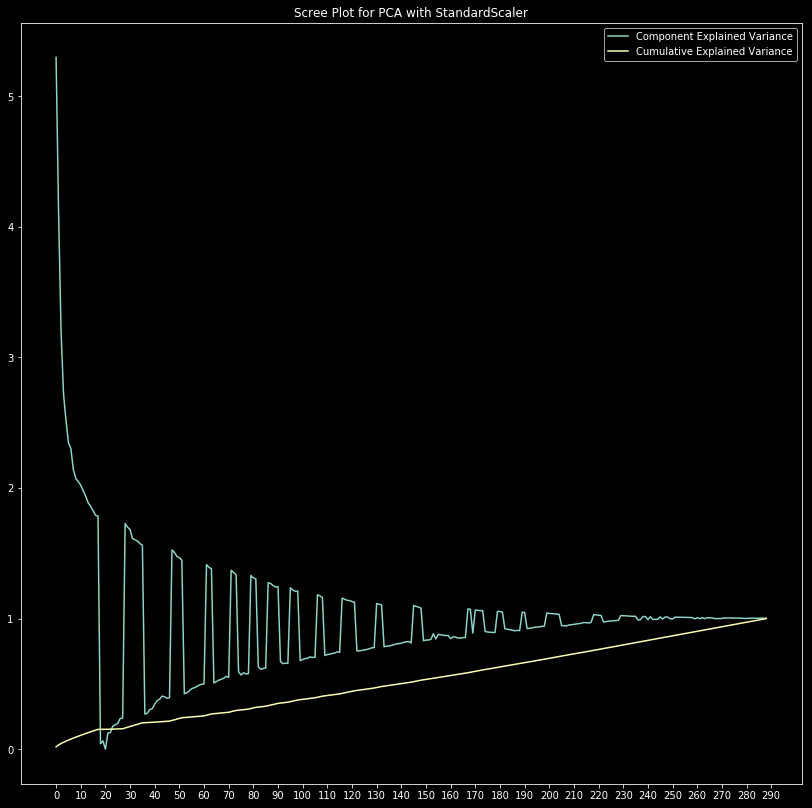

In [131]:
plt.rcParams['figure.figsize'] = 14, 14

plt.title('Scree Plot for PCA with StandardScaler')
plt.plot(eig_val_cov)
plt.plot(eig_val_cov.cumsum()/sum(eig_val_cov))
plt.xticks(np.arange(0, 300, step=10))
plt.legend(['Component Explained Variance', 'Cumulative Explained Variance'])
plt.show()

This is an odd-looking scree plot. Let's try a different normalization technique.

## PCA with MinMaxScaler

In [132]:
features_pca = features2.drop(targets, 1)

X = MinMaxScaler().fit_transform(features_pca)

Xt = X.T
Cx = np.cov(Xt)

# Calculating eigenvalues and eigenvectors.
eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)

# Inspecting the eigenvalues and eigenvectors.
for i in range(len(eig_val_cov)):
    eigvec_cov = eig_vec_cov[:, i].reshape(1, len(features2.drop(targets, 1).columns)).T

Y_sklearn = sklearn_pca.fit_transform(X)

print(
    '\nThe percentage of total variance in the dataset explained by each',
    'component from Sklearn PCA.\n',
    sklearn_pca.explained_variance_ratio_, '\nTotal explained variance:\n',
    sum(sklearn_pca.explained_variance_ratio_)
)


The percentage of total variance in the dataset explained by each component from Sklearn PCA.
 [0.04245283 0.03651836 0.03004316 0.02515947 0.02087641 0.02041622
 0.01762652 0.01621878 0.01536426 0.01512194 0.01478602 0.01369393
 0.01348894 0.01302306 0.01282174 0.01239051 0.01220597 0.0120457
 0.01178672 0.01153248 0.01123411 0.01095672 0.01076304 0.01035811
 0.01008556 0.00963707 0.00953091 0.00930311 0.00903351 0.00884862
 0.00871921 0.00830108 0.00815779 0.00785547 0.00754624 0.00738211
 0.00720263 0.00702875 0.0067857  0.00668455] 
Total explained variance:
 0.542987325574837


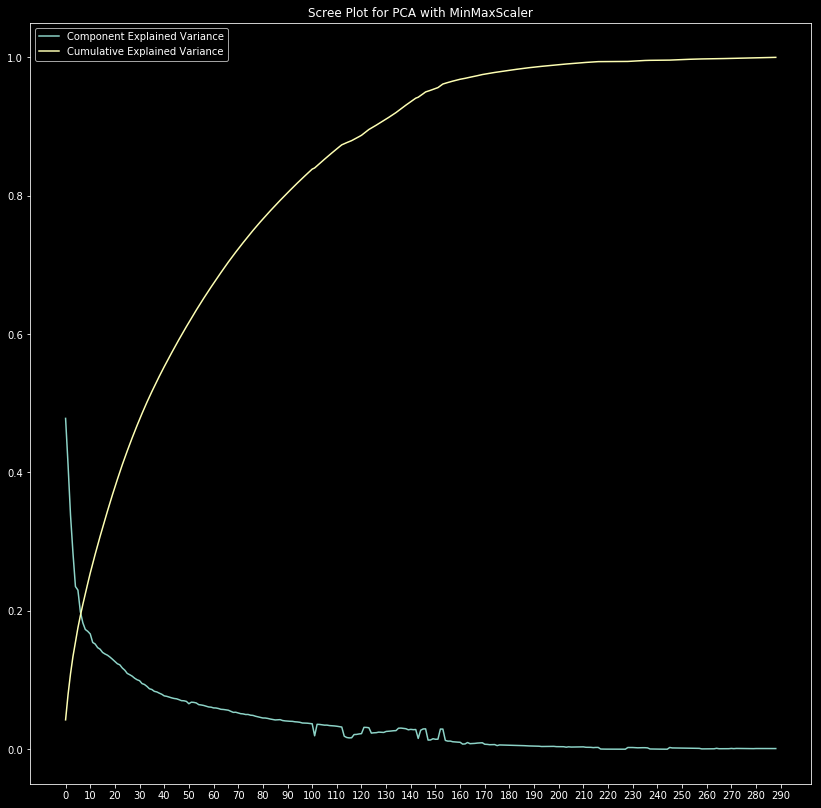

In [133]:
plt.rcParams['figure.figsize'] = 14, 14

plt.title('Scree Plot for PCA with MinMaxScaler')
plt.plot(eig_val_cov)
plt.plot(eig_val_cov.cumsum()/sum(eig_val_cov))
plt.xticks(np.arange(0, 300, step=10))
plt.legend(['Component Explained Variance', 'Cumulative Explained Variance'])
plt.show()

## PCA with MaxAbsScaler

In [134]:
features_pca = features2.drop(targets, 1)

X = MaxAbsScaler().fit_transform(features_pca)

Xt = X.T
Cx = np.cov(Xt)

# Calculating eigenvalues and eigenvectors.
eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)

# Inspecting the eigenvalues and eigenvectors.
for i in range(len(eig_val_cov)):
    eigvec_cov = eig_vec_cov[:, i].reshape(1, len(features2.drop(targets, 1).columns)).T

Y_sklearn = sklearn_pca.fit_transform(X)

print(
    '\nThe percentage of total variance in the dataset explained by each',
    'component from Sklearn PCA.\n',
    sklearn_pca.explained_variance_ratio_, '\nTotal explained variance:\n',
    sum(sklearn_pca.explained_variance_ratio_)
)


The percentage of total variance in the dataset explained by each component from Sklearn PCA.
 [0.04249355 0.03657928 0.03008858 0.02520539 0.02088928 0.02043506
 0.01764517 0.01624655 0.01537618 0.01514901 0.01480819 0.0137118
 0.01350456 0.01305194 0.01283122 0.01243201 0.01222593 0.01206924
 0.01183399 0.01152718 0.01124451 0.01094953 0.01078983 0.01038994
 0.01011374 0.00968239 0.00949984 0.00931343 0.0090407  0.00880236
 0.00865053 0.00832782 0.0082329  0.00789371 0.00759207 0.00735618
 0.0072755  0.00714548 0.00702364 0.00683743] 
Total explained variance:
 0.5442656266919783


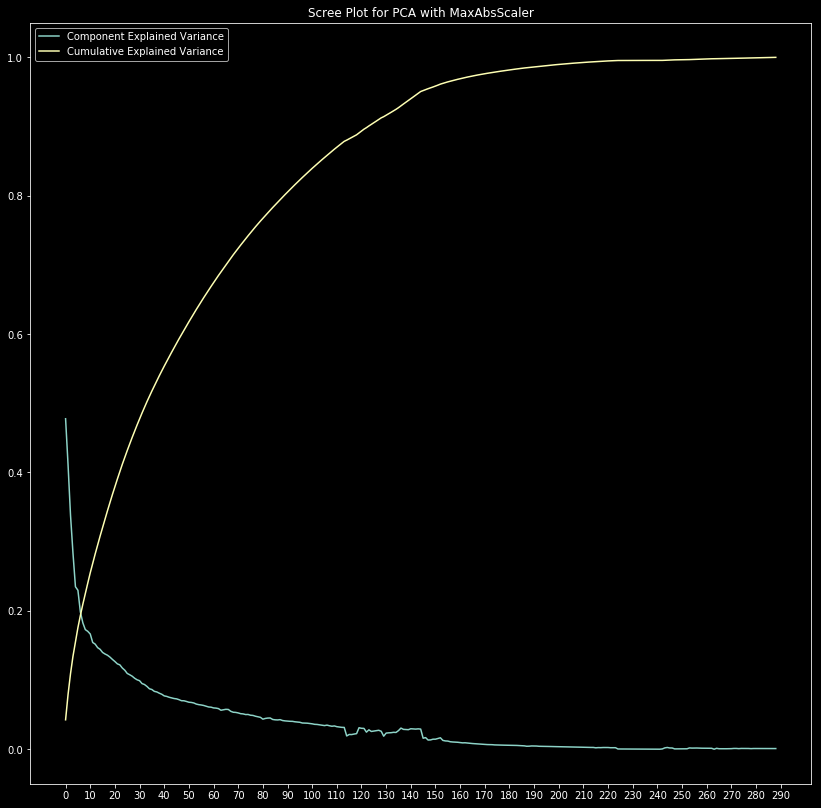

In [135]:
plt.rcParams['figure.figsize'] = 14, 14

plt.title('Scree Plot for PCA with MaxAbsScaler')
plt.plot(eig_val_cov)
plt.plot(eig_val_cov.cumsum()/sum(eig_val_cov))
plt.xticks(np.arange(0, 300, step=10))
plt.legend(['Component Explained Variance', 'Cumulative Explained Variance'])
plt.show()

Even with different normalization, this is a bit of an odd scree plot; there is more of a gradual curve than a sharp elbow. While there is certainly an eigenvalue that explains a relatively high amount of variance, the highest still only accounts for about 4.2% of the total variance. As the highest variance isn't that large to begin with, the drop in explained variance is not all that sudden. We might get better predictive results with more variables than this plot might indicate. We're going to go with about 40 features, because there is a subtle shift in slope at that point, and at 40 features, more than half the variance in the model is accounted for.

In [136]:
# Sort features by magnitude of correlation with each target variable.

corrmagnitudes = {}

for target in targets:
    nulltargets = list(targets)
    nulltargets.remove(target)
    
    corrmat = features2.drop(nulltargets, 1).corr()
    
    corrmagnitude = pd.DataFrame(corrmat[target]).reset_index()
    corrmagnitude[target] = corrmagnitude[target].apply(lambda x: abs(x))

    corrmagnitude = corrmagnitude.sort_values(by=target, ascending=False)
    
    corrmagnitudes[target] = corrmagnitude

In [137]:
logprice_top = corrmagnitudes['logprice']['index'][1:n_features+1].tolist()

In [138]:
logprice_top

['words_in_description',
 'varietal_pinot noir',
 'descriptor_years',
 'descriptor_age',
 'province_us: california',
 'descriptor_tannins',
 'varietal_nebbiolo',
 'descriptor_vineyard',
 'province_france: burgundy',
 'descriptor_rich',
 'descriptor_easy',
 'descriptor_licorice',
 'varietal_sauvignon blanc',
 'varietal_rose',
 'descriptor_cherry',
 'varietal_other_white',
 'descriptor_dark',
 'descriptor_citrus',
 'descriptor_complex',
 'descriptor_fresh',
 'province_italy: piedmont',
 'descriptor_apple',
 'descriptor_structure',
 'province_france: champagne',
 'descriptor_fruity',
 'descriptor_melon',
 'descriptor_light',
 'descriptor_crisp',
 'descriptor_chocolate',
 'descriptor_clean',
 'varietal_cabernet sauvignon',
 'descriptor_flavor',
 'descriptor_time',
 'descriptor_tobacco',
 'descriptor_oak',
 'descriptor_new',
 'descriptor_long',
 'descriptor_fine',
 'descriptor_firm',
 'descriptor_dried']

In [139]:
points_top = corrmagnitudes['points']['index'][1:n_features+1].tolist()

In [140]:
points_top

['words_in_description',
 'descriptor_rich',
 'descriptor_complex',
 'descriptor_years',
 'descriptor_vineyard',
 'descriptor_age',
 'descriptor_structure',
 'descriptor_fine',
 'descriptor_concentrated',
 'descriptor_full',
 'descriptor_dark',
 'descriptor_delicious',
 'descriptor_long',
 'descriptor_firm',
 'descriptor_dense',
 'descriptor_elegant',
 'descriptor_mineral',
 'descriptor_tannins',
 'descriptor_great',
 'descriptor_balance',
 'descriptor_drink',
 'descriptor_spice',
 'descriptor_bit',
 'varietal_pinot noir',
 'descriptor_easy',
 'descriptor_licorice',
 'descriptor_yet',
 'descriptor_flavor',
 'descriptor_aging',
 'descriptor_cassis',
 'descriptor_time',
 'descriptor_new',
 'descriptor_best',
 'descriptor_still',
 'descriptor_ripe',
 'descriptor_chocolate',
 'descriptor_green',
 'province_argentina: mendoza province',
 'varietal_nebbiolo',
 'descriptor_vintage']

In [141]:
high_rating_top = corrmagnitudes['high_rating']['index'][1:n_features+1].tolist()

In [142]:
high_rating_top

['words_in_description',
 'descriptor_complex',
 'descriptor_vineyard',
 'descriptor_years',
 'descriptor_rich',
 'descriptor_age',
 'descriptor_structure',
 'descriptor_fine',
 'descriptor_concentrated',
 'varietal_pinot noir',
 'descriptor_dark',
 'descriptor_full',
 'descriptor_dense',
 'descriptor_delicious',
 'descriptor_great',
 'descriptor_elegant',
 'descriptor_easy',
 'descriptor_firm',
 'descriptor_best',
 'descriptor_mineral',
 'descriptor_long',
 'descriptor_drink',
 'descriptor_yet',
 'descriptor_time',
 'descriptor_aging',
 'descriptor_cassis',
 'descriptor_new',
 'descriptor_still',
 'province_france: champagne',
 'descriptor_licorice',
 'descriptor_chocolate',
 'descriptor_bit',
 'province_us: california',
 'descriptor_balance',
 'descriptor_fruity',
 'descriptor_vintage',
 'varietal_other_white',
 'descriptor_light',
 'descriptor_spice',
 'descriptor_tannins']

In [143]:
thirtyormore_top = corrmagnitudes['thirty_or_more']['index'][1:n_features+1].tolist()

In [144]:
thirtyormore_top

['words_in_description',
 'varietal_pinot noir',
 'province_us: california',
 'descriptor_vineyard',
 'descriptor_years',
 'descriptor_age',
 'varietal_nebbiolo',
 'descriptor_tannins',
 'varietal_other_white',
 'descriptor_cherry',
 'varietal_sauvignon blanc',
 'varietal_rose',
 'descriptor_licorice',
 'descriptor_fresh',
 'descriptor_citrus',
 'descriptor_apple',
 'descriptor_crisp',
 'descriptor_melon',
 'descriptor_easy',
 'descriptor_complex',
 'descriptor_dark',
 'descriptor_rich',
 'descriptor_fruity',
 'descriptor_chocolate',
 'descriptor_oak',
 'descriptor_dried',
 'descriptor_peach',
 'descriptor_clean',
 'province_italy: piedmont',
 'descriptor_new',
 'descriptor_light',
 'descriptor_tobacco',
 'descriptor_time',
 'varietal_cabernet sauvignon',
 'vintage',
 'province_france: burgundy',
 'descriptor_structure',
 'descriptor_leather',
 'descriptor_berry',
 'descriptor_blackberry']

In [145]:
columnlist = features_pca.columns
X_normed = pd.DataFrame(X, columns=columnlist)

# Regression Modeling:

## Price Regression (as logprice):

The first outcome of interest for this dataset is price. A predictive model of a wine's price based on information found on the bottle (origin, varietal, and description) could be useful both to wine sellers and to consumers. Wineries and retailers could use such a model to help set the price point at which to sell their wine, and customers would likely find an estimation of price based on these variables useful to avoid overpaying.

### Ordinary Least Squares Regression:

In [146]:
Y = features2['logprice']
X_train, X_test, Y_train, Y_test = train_test_split(X_normed[logprice_top], Y, test_size=0.333, random_state=0)

In [147]:
ols = linear_model.LinearRegression()

In [148]:
ols.fit(X_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [149]:
ols.score(X_train, Y_train)

0.3538495579080928

In [150]:
ols.score(X_test, Y_test)

0.3498228071607208

In [151]:
mean_squared_error(Y_test, ols.predict(X_test))

0.2729195897779904

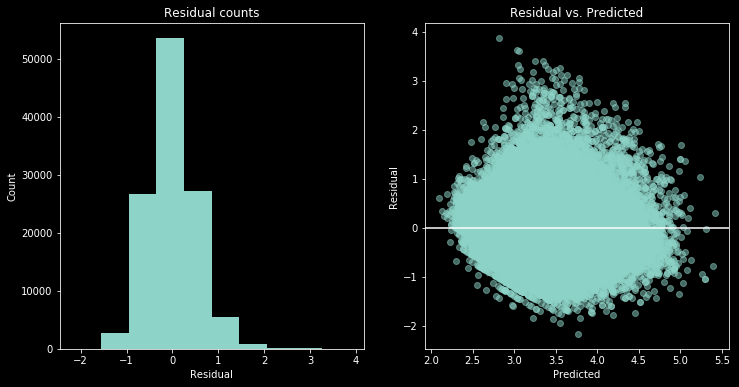

In [152]:
predicted = ols.predict(X_normed[logprice_top]).ravel()
actual = Y

residual = actual - predicted

plt.rcParams['figure.figsize'] = 12, 6

plt.subplot(1, 2, 1)
plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
plt.scatter(predicted, residual, alpha=0.5) 
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

### LASSO Linear Regression:

In [153]:
lassoreg1 = linear_model.Lasso(alpha=0.001, tol=0.00001)

In [154]:
lassoreg1.fit(X_train, Y_train)

Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=1e-05, warm_start=False)

In [155]:
lassoreg1.score(X_train, Y_train)

0.35223903068612017

In [156]:
lassoreg1.score(X_test, Y_test)

0.3485836024174006

In [157]:
mean_squared_error(Y_test, lassoreg1.predict(X_test))

0.27343976066974524

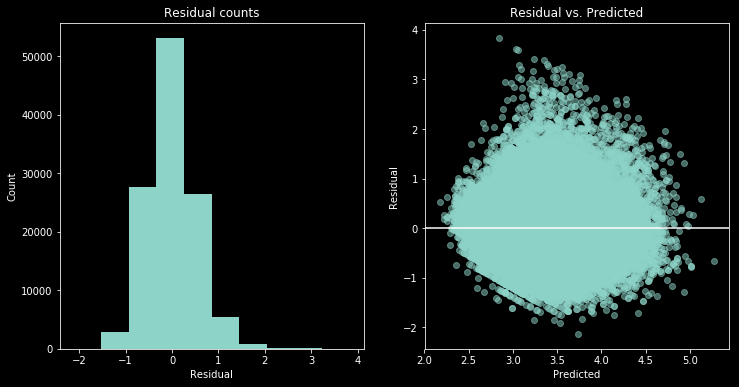

In [158]:
predicted = lassoreg1.predict(X_normed[logprice_top]).ravel()
actual = Y

residual = actual - predicted

plt.rcParams['figure.figsize'] = 12, 6

plt.subplot(1, 2, 1)
plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
plt.scatter(predicted, residual, alpha=0.5) 
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

### KNN Regression

In [159]:
knn = KNeighborsRegressor(n_neighbors=10)

In [160]:
knn.fit(X_train, Y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=10, p=2,
          weights='uniform')

In [161]:
knn.score(X_train, Y_train)

0.4314253325808939

In [162]:
knn.score(X_test, Y_test)

0.30295398059785905

In [163]:
mean_squared_error(Y_test, knn.predict(X_test))

0.2925933357349237

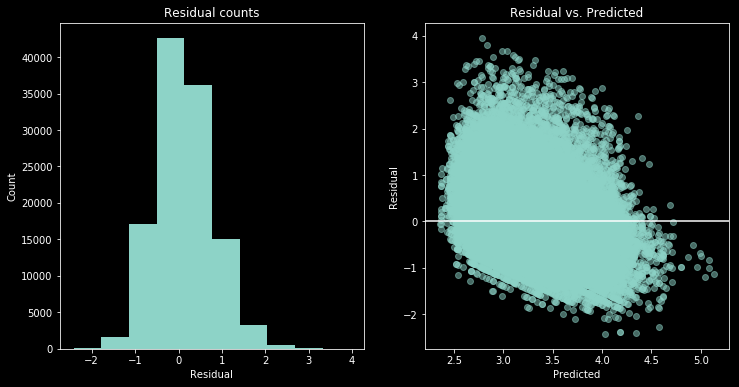

In [164]:
predicted = knn.predict(X_normed[points_top]).ravel()
actual = Y

residual = actual - predicted

plt.rcParams['figure.figsize'] = 12, 6

plt.subplot(1, 2, 1)
plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
plt.scatter(predicted, residual, alpha=0.5) 
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

## Modeling Points:

### Ordinary Least Squares Regression:

In [165]:
Y = features2['points']
X_train, X_test, Y_train, Y_test = train_test_split(X_normed[points_top], Y, test_size=0.333, random_state=0)

In [166]:
ols = linear_model.LinearRegression(n_jobs=-1)

In [167]:
ols.fit(X_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [168]:
ols.score(X_train, Y_train)

0.44537982376181773

In [169]:
ols.score(X_test, Y_test)

0.44462047427426815

In [170]:
mean_squared_error(Y_test, ols.predict(X_test))

5.146516169026247

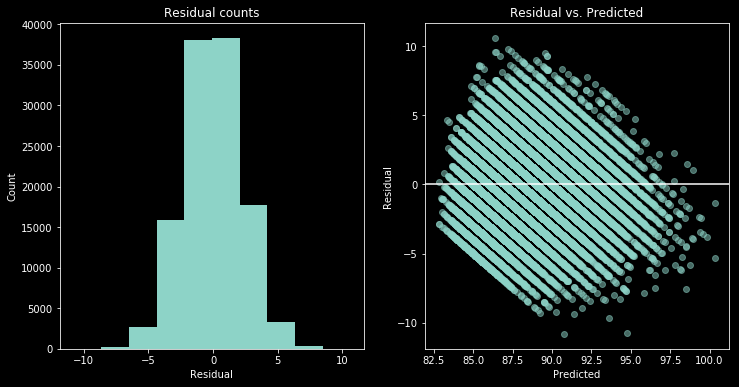

In [171]:
predicted = ols.predict(X_normed[points_top]).ravel()
actual = Y

residual = actual - predicted

plt.rcParams['figure.figsize'] = 12, 6

plt.subplot(1, 2, 1)
plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
plt.scatter(predicted, residual, alpha=0.5) 
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

### Lasso Linear Regression:

In [172]:
lassoreg1 = linear_model.Lasso(alpha = 0.001)

In [173]:
lassoreg1.fit(X_train, Y_train)

Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [174]:
lassoreg1.score(X_train, Y_train)

0.4453161955440402

In [175]:
lassoreg1.score(X_test, Y_test)

0.4445127862378035

In [176]:
mean_squared_error(Y_test, lassoreg1.predict(X_test))

5.147514078014973

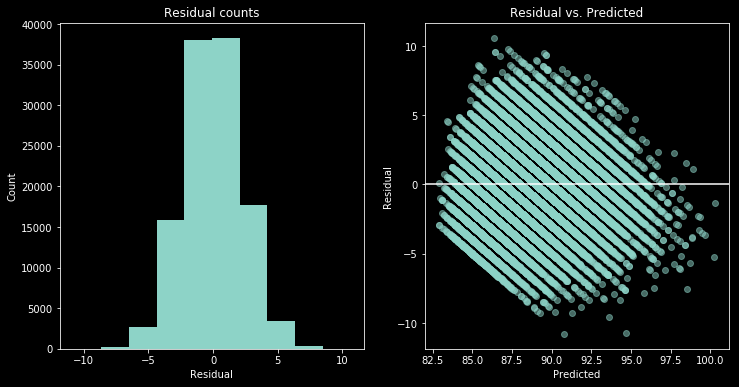

In [177]:
predicted = lassoreg1.predict(X_normed[points_top]).ravel()
actual = Y

residual = actual - predicted

plt.rcParams['figure.figsize'] = 12, 6

plt.subplot(1, 2, 1)
plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
plt.scatter(predicted, residual, alpha=0.5) 
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

### KNN Regression

In [178]:
knn = KNeighborsRegressor(n_neighbors=10)

In [179]:
knn.fit(X_train, Y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=10, p=2,
          weights='uniform')

In [180]:
knn.score(X_train, Y_train)

0.4723179528791925

In [181]:
knn.score(X_test, Y_test)

0.36537084255841257

In [182]:
mean_squared_error(Y_test, knn.predict(X_test))

5.8808959798089075

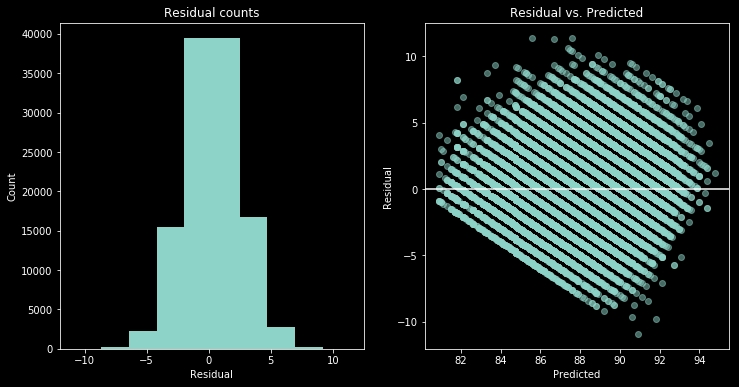

In [183]:
predicted = knn.predict(X_normed[points_top]).ravel()
actual = Y

residual = actual - predicted

plt.rcParams['figure.figsize'] = 12, 6

plt.subplot(1, 2, 1)
plt.hist(residual)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
plt.scatter(predicted, residual, alpha=0.5) 
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

Regression for both price and point score yields odd residuals and, particularly in the case of points, abnormally high mean-squared error. We may have better luck treating these models as classification problems.

# Classification Modeling:

The mean price of wines included is slightly higher than \$30, and the median price is $30, so we'll use that as a cutoff point for high/low prices. For points scores, we'll use 90 as a cutoff point because of the implicit quality distinction between the corresponding "A" and "B" ratings, and because it's fairly close to the central tendencies for points (88 median, 88.6 mean).

These models will not be as useful as regression models would be for retailers, as their precision is drastically reduced, but they might still hold value for consumers seeking to make a decision on whether or not to purchase a bottle of wine.

Given description, origin, and variety, should one expect to pay more or less than $30 for a bottle of a specific wine? Is the quality of that wine merely good, or truly exceptional?

We are obviously looking for high accuracy in these models, but between sensitivity and specificity, we care more about specificity, as the drawback of paying too much for a lower-quality wine is worse than that of not buying a wine that is in fact of high-quality.

## Modeling Price:

In [184]:
Y = features2['thirty_or_more']
X_train, X_test, Y_train, Y_test = train_test_split(X_normed[thirtyormore_top], Y, test_size=0.333, random_state=0)

### Logistic Regression:

In [185]:
lr0 = LogisticRegression()

In [186]:
lr0.fit(X_train, Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [187]:
lr0.score(X_train, Y_train)

0.7308354977241752

In [188]:
lr0.score(X_test, Y_test)

0.7263128074377398

In [189]:
testresults = pd.crosstab(lr0.predict(X_test), Y_test, margins=True)

In [190]:
testresults

thirty_or_more,0,1,All
row_0,,,
0,17586,6335,23921
1,4292,10616,14908
All,21878,16951,38829


In [191]:
testtype1 = testresults[1][0]/testresults.loc['All','All']
print('\nType I errors: ', testtype1)

testtype2 = testresults[0][1]/testresults.loc['All','All']
print('Type II errors: ', testtype2)

testsens = testresults[1][1]/(testresults[1][1]+testresults[0][1])
print('Sensitivity: ', testsens)

testspec = testresults[0][0]/(testresults[0][0]+testresults[1][0])
print('Specificity: ', testspec)


Type I errors:  0.16315125292951144
Type II errors:  0.11053593963274871
Sensitivity:  0.7121008854306413
Specificity:  0.7351699343672924


### Lasso Logistic Regression

In [192]:
lrl1 = LogisticRegression(penalty='l1', max_iter=200)

In [193]:
lrl1 = LogisticRegression(penalty='l1', C=0.1, max_iter=200)

In [194]:
lrl1.fit(X_train, Y_train)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=200, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [195]:
lrl1.score(X_train, Y_train)

0.7306554889808934

In [196]:
lrl1.score(X_test, Y_test)

0.7260037600762317

In [197]:
testresults = pd.crosstab(lrl1.predict(X_test), Y_test, margins=True)

In [198]:
testresults

thirty_or_more,0,1,All
row_0,,,
0,17597,6358,23955
1,4281,10593,14874
All,21878,16951,38829


In [199]:
testtype1 = testresults[1][0]/testresults.loc['All','All']
print('\nType I errors: ', testtype1)

testtype2 = testresults[0][1]/testresults.loc['All','All']
print('Type II errors: ', testtype2)

testsens = testresults[1][1]/(testresults[1][1]+testresults[0][1])
print('Sensitivity: ', testsens)

testspec = testresults[0][0]/(testresults[0][0]+testresults[1][0])
print('Specificity: ', testspec)


Type I errors:  0.1637435937057354
Type II errors:  0.11025264621803291
Sensitivity:  0.7121823315853166
Specificity:  0.7345856814861198


### Random Forest Classification

In [200]:
rfc = ensemble.RandomForestClassifier()

In [201]:
rfc.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [202]:
rfc.score(X_train, Y_train)

0.9664798004474503

In [203]:
rfc.score(X_test, Y_test)

0.7286564165958433

In [204]:
testresults = pd.crosstab(rfc.predict(X_test), Y_test, margins=True)

In [205]:
testresults

thirty_or_more,0,1,All
row_0,,,
0,17441,6099,23540
1,4437,10852,15289
All,21878,16951,38829


In [206]:
testtype1 = testresults[1][0]/testresults.loc['All','All']
print('\nType I errors: ', testtype1)

testtype2 = testresults[0][1]/testresults.loc['All','All']
print('Type II errors: ', testtype2)

testsens = testresults[1][1]/(testresults[1][1]+testresults[0][1])
print('Sensitivity: ', testsens)

testspec = testresults[0][0]/(testresults[0][0]+testresults[1][0])
print('Specificity: ', testspec)


Type I errors:  0.15707332148651781
Type II errors:  0.11427026191763888
Sensitivity:  0.7097913532605141
Specificity:  0.740909090909091


### Gradient Boosting Decision Tree Classifier

#### Grid Search CV:

In [207]:
gbdt = ensemble.GradientBoostingClassifier(n_estimators=200, max_depth=12)

In [208]:
"""param_grid = {'loss': ['deviance', 'exponential'],
              'min_samples_split':[50, 100]}

gbgridsearch = GridSearchCV(gbdt, param_grid, return_train_score=True, cv=3)
gbgridsearch.fit(X_train, Y_train)"""

"param_grid = {'loss': ['deviance', 'exponential'],\n              'min_samples_split':[50, 100]}\n\ngbgridsearch = GridSearchCV(gbdt, param_grid, return_train_score=True, cv=3)\ngbgridsearch.fit(X_train, Y_train)"

In [209]:
"""pd.DataFrame(gbgridsearch.cv_results_).to_csv('GridSearchGradBoostPrice.csv')"""

"pd.DataFrame(gbgridsearch.cv_results_).to_csv('GridSearchGradBoostPrice.csv')"

In [210]:
pd.read_csv('GridSearchGradBoostPrice.csv', index_col=0)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_loss,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,161.015403,3.704890,0.306648,0.004558,deviance,50,"{'loss': 'deviance', 'min_samples_split': 50}",0.742334,0.743645,0.742439,0.742806,0.000595,4,0.868117,0.866979,0.869219,0.868105,0.000914
1,129.861673,2.638527,0.292998,0.005212,deviance,100,"{'loss': 'deviance', 'min_samples_split': 100}",0.743491,0.745304,0.742825,0.743873,0.001047,3,0.844896,0.842003,0.844860,0.843920,0.001355
2,172.593345,1.839849,0.315136,0.009082,exponential,50,"{'loss': 'exponential', 'min_samples_split': 50}",0.745342,0.744879,0.744522,0.744915,0.000336,2,0.870489,0.868406,0.867541,0.868812,0.001237
3,134.929326,0.784293,0.299962,0.002758,exponential,100,"{'loss': 'exponential', 'min_samples_split': 100}",0.746770,0.744571,0.745795,0.745712,0.000900,1,0.837798,0.839708,0.838689,0.838731,0.000780


The GridSearchCV battery shows us that exponential loss and a min_samples_split parameter of 100 provide the best results for this classifier.

In [211]:
"""gbgridsearch.best_estimator_"""

'gbgridsearch.best_estimator_'

#### Final Hyperparameters:

In [212]:
gbdt = ensemble.GradientBoostingClassifier(n_estimators=200, max_depth=12, loss='exponential', min_samples_split=100)

In [213]:
gbdt.fit(X_train, Y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='exponential', max_depth=12,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=100,
              min_weight_fraction_leaf=0.0, n_estimators=200,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [214]:
gbdt.score(X_train, Y_train)

0.827847352585697

In [215]:
gbdt.score(X_test, Y_test)

0.7460145767338845

In [216]:
gbdtcvscore = cross_val_score(gbdt, X_normed[thirtyormore_top], Y, cv=5, n_jobs=-1)

In [217]:
gbdtcvscore

array([0.74083444, 0.75275503, 0.74250675, 0.74845626, 0.760506  ])

In [218]:
gbdtcvscore.mean()

0.7490116972879735

In [219]:
gbdtcvscore.std()*2

0.01430026343539371

In [220]:
testresults = pd.crosstab(gbdt.predict(X_test), Y_test, margins=True)

In [221]:
testresults

thirty_or_more,0,1,All
row_0,,,
0,17614,5598,23212
1,4264,11353,15617
All,21878,16951,38829


In [222]:
testtype1 = testresults[1][0]/testresults.loc['All','All']
print('\nType I errors: ', testtype1)

testtype2 = testresults[0][1]/testresults.loc['All','All']
print('Type II errors: ', testtype2)

testsens = testresults[1][1]/(testresults[1][1]+testresults[0][1])
print('Sensitivity: ', testsens)

testspec = testresults[0][0]/(testresults[0][0]+testresults[1][0])
print('Specificity: ', testspec)


Type I errors:  0.1441705941435525
Type II errors:  0.10981482912256303
Sensitivity:  0.7269642056733048
Specificity:  0.7588316388075134


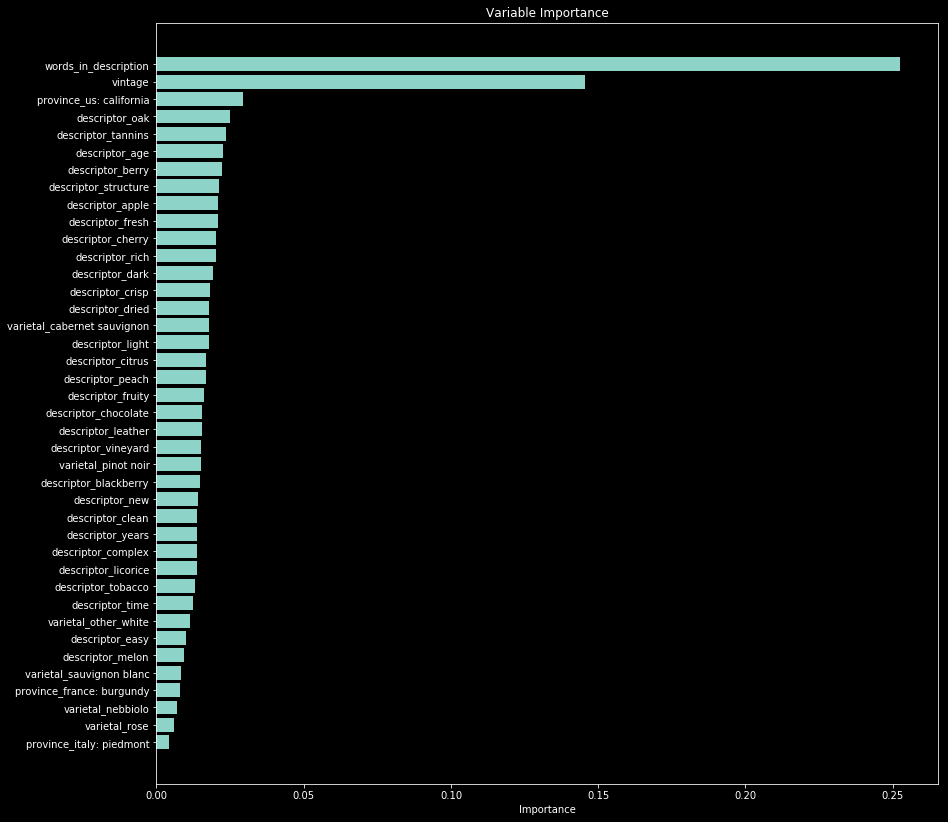

In [223]:
feature_importance = gbdt.feature_importances_[:n_features]

# Size bars for importances relative to max importance.
plt.figure(figsize=(14, 14))
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_normed[thirtyormore_top].columns[sorted_idx])
plt.xlabel('Importance')
plt.title('Variable Importance')
plt.show()

In [224]:
thirtyormore_top

['words_in_description',
 'varietal_pinot noir',
 'province_us: california',
 'descriptor_vineyard',
 'descriptor_years',
 'descriptor_age',
 'varietal_nebbiolo',
 'descriptor_tannins',
 'varietal_other_white',
 'descriptor_cherry',
 'varietal_sauvignon blanc',
 'varietal_rose',
 'descriptor_licorice',
 'descriptor_fresh',
 'descriptor_citrus',
 'descriptor_apple',
 'descriptor_crisp',
 'descriptor_melon',
 'descriptor_easy',
 'descriptor_complex',
 'descriptor_dark',
 'descriptor_rich',
 'descriptor_fruity',
 'descriptor_chocolate',
 'descriptor_oak',
 'descriptor_dried',
 'descriptor_peach',
 'descriptor_clean',
 'province_italy: piedmont',
 'descriptor_new',
 'descriptor_light',
 'descriptor_tobacco',
 'descriptor_time',
 'varietal_cabernet sauvignon',
 'vintage',
 'province_france: burgundy',
 'descriptor_structure',
 'descriptor_leather',
 'descriptor_berry',
 'descriptor_blackberry']

## Modeling Points:

In [225]:
Y = features2['high_rating']
X_train, X_test, Y_train, Y_test = train_test_split(X_normed[high_rating_top+['vintage']], Y, test_size=0.333, random_state=0)

### Logistic Regression:

In [226]:
lr0 = LogisticRegression()

In [227]:
lr0.fit(X_train, Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [228]:
lr0.score(X_train, Y_train)

0.8037133232185564

In [229]:
lr0.score(X_test, Y_test)

0.8023899662623297

In [230]:
testresults = pd.crosstab(lr0.predict(X_test), Y_test, margins=True)

In [231]:
testresults

high_rating,0,1,All
row_0,,,
0,26535,5500,32035
1,2173,4621,6794
All,28708,10121,38829


In [232]:
testtype1 = testresults[1][0]/testresults.loc['All','All']
print('\nType I errors: ', testtype1)

testtype2 = testresults[0][1]/testresults.loc['All','All']
print('Type II errors: ', testtype2)

testsens = testresults[1][1]/(testresults[1][1]+testresults[0][1])
print('Sensitivity: ', testsens)

testspec = testresults[0][0]/(testresults[0][0]+testresults[1][0])
print('Specificity: ', testspec)


Type I errors:  0.1416467073579026
Type II errors:  0.0559633263797677
Sensitivity:  0.6801589637915808
Specificity:  0.82831278289371


### Lasso Logistic Regression

In [233]:
lrl1 = LogisticRegression(penalty='l1', C=0.1, max_iter=200)

In [234]:
lrl1.fit(X_train, Y_train)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=200, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [235]:
lrl1.score(X_train, Y_train)

0.8039190474965927

In [236]:
lrl1.score(X_test, Y_test)

0.802853537304592

In [237]:
testresults = pd.crosstab(lrl1.predict(X_test), Y_test, margins=True)

In [238]:
testresults

high_rating,0,1,All
row_0,,,
0,26563,5510,32073
1,2145,4611,6756
All,28708,10121,38829


In [239]:
testtype1 = testresults[1][0]/testresults.loc['All','All']
print('\nType I errors: ', testtype1)

testtype2 = testresults[0][1]/testresults.loc['All','All']
print('Type II errors: ', testtype2)

testsens = testresults[1][1]/(testresults[1][1]+testresults[0][1])
print('Sensitivity: ', testsens)

testspec = testresults[0][0]/(testresults[0][0]+testresults[1][0])
print('Specificity: ', testspec)


Type I errors:  0.14190424682582606
Type II errors:  0.055242215869582015
Sensitivity:  0.6825044404973357
Specificity:  0.8282044086926699


### Random Forest Classification

In [240]:
rfc = ensemble.RandomForestClassifier(min_samples_split=100)

In [241]:
rfc.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=100,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [242]:
rfc.score(X_train, Y_train)

0.8294288579731015

In [243]:
rfc.score(X_test, Y_test)

0.8073089700996677

In [244]:
testresults = pd.crosstab(rfc.predict(X_test), Y_test, margins=True)

In [245]:
testresults

high_rating,0,1,All
row_0,,,
0,26502,5276,31778
1,2206,4845,7051
All,28708,10121,38829


In [246]:
testtype1 = testresults[1][0]/testresults.loc['All','All']
print('\nType I errors: ', testtype1)

testtype2 = testresults[0][1]/testresults.loc['All','All']
print('Type II errors: ', testtype2)

testsens = testresults[1][1]/(testresults[1][1]+testresults[0][1])
print('Sensitivity: ', testsens)

testspec = testresults[0][0]/(testresults[0][0]+testresults[1][0])
print('Specificity: ', testspec)


Type I errors:  0.13587782327641712
Type II errors:  0.05681320662391511
Sensitivity:  0.6871365763721458
Specificity:  0.8339731889986783


### Gradient Boosting Decision Tree Classifier

#### Grid Search CV:

In [247]:
gbdt = ensemble.GradientBoostingClassifier(n_estimators=200, max_depth=12)

In [248]:
"""param_grid = {'loss': ['deviance', 'exponential'],
              'min_samples_split':[50, 100]}

gbgridsearch = GridSearchCV(gbdt, param_grid, return_train_score=True, cv=3)
gbgridsearch.fit(X_train, Y_train)"""

"param_grid = {'loss': ['deviance', 'exponential'],\n              'min_samples_split':[50, 100]}\n\ngbgridsearch = GridSearchCV(gbdt, param_grid, return_train_score=True, cv=3)\ngbgridsearch.fit(X_train, Y_train)"

In [249]:
"""pd.DataFrame(gbgridsearch.cv_results_).to_csv('GridSearchGradBoostPoints.csv')"""

"pd.DataFrame(gbgridsearch.cv_results_).to_csv('GridSearchGradBoostPoints.csv')"

In [250]:
pd.read_csv('GridSearchGradBoostPoints.csv', index_col=0)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_loss,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,208.449118,1.688948,0.313937,0.012330,deviance,50,"{'loss': 'deviance', 'min_samples_split': 50}",0.811572,0.812112,0.816888,0.813524,0.002389,4,0.940192,0.941561,0.940887,0.940880,0.000559
1,160.094297,0.459309,0.292350,0.004102,deviance,100,"{'loss': 'deviance', 'min_samples_split': 100}",0.815275,0.813269,0.817196,0.815247,0.001603,2,0.919227,0.920056,0.918226,0.919170,0.000748
2,225.560301,10.044801,0.321357,0.002655,exponential,50,"{'loss': 'exponential', 'min_samples_split': 50}",0.814658,0.813038,0.816116,0.814604,0.001257,3,0.940732,0.939189,0.940309,0.940076,0.000651
3,174.395160,3.384157,0.320504,0.014946,exponential,100,"{'loss': 'exponential', 'min_samples_split': 100}",0.814812,0.814658,0.816618,0.815362,0.000890,1,0.917125,0.919960,0.918727,0.918604,0.001161


In [251]:
"""gbgridsearch.best_estimator_"""

'gbgridsearch.best_estimator_'

GridSearchCV for modeling high_rating shows the same results as for thirty_or_more; min_samples_split at 100, and exponential loss function produce the best accuracy for this model.

#### Final Hyperparameters:

In [252]:
gbdt = ensemble.GradientBoostingClassifier(n_estimators=200, max_depth=12, loss='exponential', min_samples_split=100)

In [253]:
gbdt.fit(X_train, Y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='exponential', max_depth=12,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=100,
              min_weight_fraction_leaf=0.0, n_estimators=200,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [254]:
gbdt.score(X_train, Y_train)

0.9097513307789236

In [255]:
gbdt.score(X_test, Y_test)

0.8190785237837699

In [256]:
gbdtcvscore = cross_val_score(gbdt, X_normed[high_rating_top], Y, cv=5, n_jobs=-1)

In [257]:
gbdtcvscore

array([0.81433043, 0.81767506, 0.81008533, 0.81480211, 0.81594408])

In [258]:
gbdtcvscore.mean()

0.8145674018108989

In [259]:
gbdtcvscore.std()*2

0.005040076606326775

In [260]:
testresults = pd.crosstab(gbdt.predict(X_test), Y_test, margins=True)

In [261]:
testresults

high_rating,0,1,All
row_0,,,
0,26299,4616,30915
1,2409,5505,7914
All,28708,10121,38829


In [262]:
testtype1 = testresults[1][0]/testresults.loc['All','All']
print('\nType I errors: ', testtype1)

testtype2 = testresults[0][1]/testresults.loc['All','All']
print('Type II errors: ', testtype2)

testsens = testresults[1][1]/(testresults[1][1]+testresults[0][1])
print('Sensitivity: ', testsens)

testspec = testresults[0][0]/(testresults[0][0]+testresults[1][0])
print('Specificity: ', testspec)


Type I errors:  0.1188802183934688
Type II errors:  0.06204125782276134
Sensitivity:  0.6956027293404095
Specificity:  0.8506873685912987


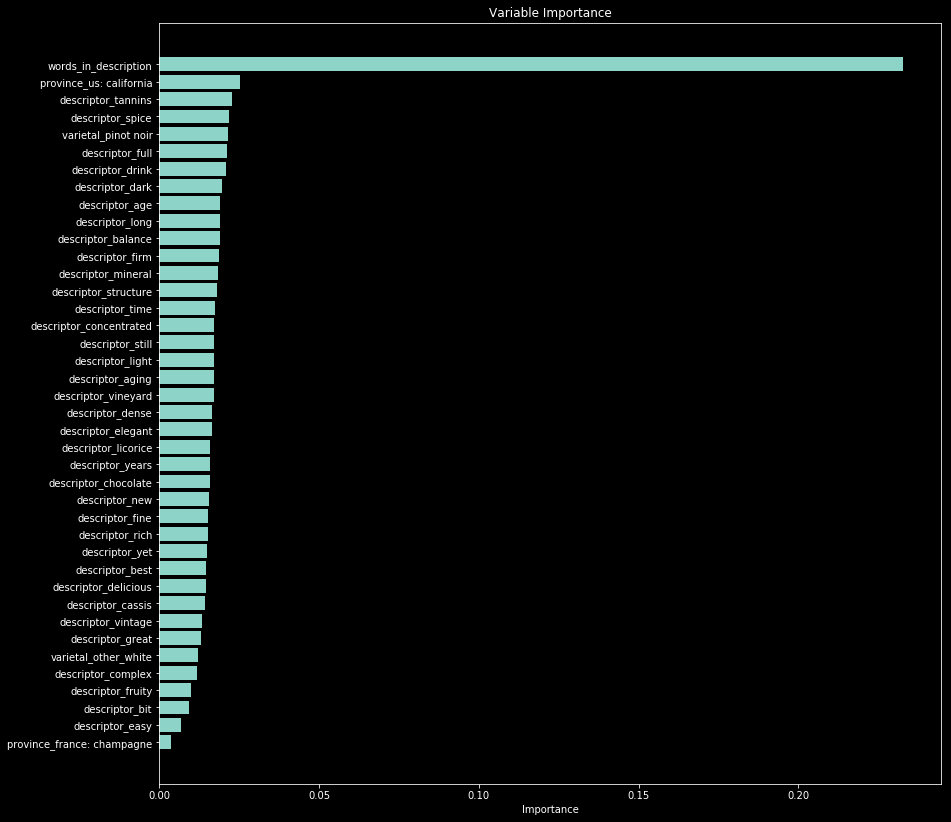

In [263]:
feature_importance = gbdt.feature_importances_[:n_features]

# Size bars for importances relative to max importance.
plt.figure(figsize=(14, 14))
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_normed[high_rating_top].columns[sorted_idx])
plt.xlabel('Importance')
plt.title('Variable Importance')
plt.show()

# Conlusions:

For both price and rating, gradient-boosted decision tree modeling proved to be the most accurate. Results with regression models were disappointingly low for this dataset, but it might be possible to improve them with the inclusion of more information or other modeling techniques for descriptive terms.

Future projects based on this dataset could include a full-fledged sentiment analysis using NLTK or SpaCy, which could be used for better prediction of rating and/or price.

The same sort of model could be applied to user-submitted information for beer review websites such as RateBeer, BeerAdvocate, and Untappd.